In [99]:
import os
os. getcwd()

import pandas as pd
import numpy as np
import sklearn.preprocessing
from sklearn.impute import SimpleImputer
df = pd.read_csv('HMEQ_loan_data.csv')


print('Total NaN Values =',df.isnull().sum().sum()) # this counts the total number of NaN in both rows and columns, which outputs 5271 (an issue I will deal with)
print(df.isnull().sum()) # this shows which columns and how many in each column are missing values
# there are 11 columns that have missing values
# there are 5271 total missing records 
# the most NaN are in DEBTINC which is likely due to not knowing the income of some obligators

df.dropna(subset = ["REASON"], inplace=True)
df.dropna(subset = ["JOB"], inplace=True)
df.dropna(subset = ["DEBTINC"], inplace=True)
df.dropna(subset = ["DEROG"], inplace=True)
df.dropna(subset = ["DELINQ"], inplace=True)
df.dropna(subset = ["MORTDUE"], inplace=True)
df.dropna(subset = ["YOJ"], inplace=True)
df.dropna(subset = ["NINQ"], inplace=True)
df.dropna(subset = ["CLAGE"], inplace=True)
df.dropna(subset = ["VALUE"], inplace=True)
# Normally I would only remove NaN for categorical but in the case of loan data that is very specific I think it is fit to reomve numerical columns too
# Being that some of these metrics are ratios, it is not fair to input a median or mean and garner valuable mitigated results

print()
print('Total NaN Values after Dealing with categorical & numerical variables =',df.isnull().sum().sum()) # this shows now that there are only 54 values NaN
# This final print statement shows that there are no more NaN values in the entire dataset
print(df.isnull().sum())
print()

from pandas import DataFrame
from numpy import mean
print('Total rows in dataset ',len(df))  # originally there are 5960 rows in the dataset, but now only 3364 after controlling for NaN values
print('Total rows in dataset after removing duplicates ',len(df.drop_duplicates())) # there are still 3364 rows after dropping duplicates (so no duplicate records in the data)
print('Number of duplicates removed ',len(df)-len(df.drop_duplicates())) # there are 0 duplicate records in the dataset when checking the lengths of the dataset and the length of duplicate rows

print()
df.shape # dimensions of the dataset after cleaning




Total NaN Values = 5271
BAD           0
LOAN          0
MORTDUE     518
VALUE       112
REASON      252
JOB         279
YOJ         515
DEROG       708
DELINQ      580
CLAGE       308
NINQ        510
CLNO        222
DEBTINC    1267
dtype: int64

Total NaN Values after Dealing with categorical & numerical variables = 0
BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

Total rows in dataset  3364
Total rows in dataset after removing duplicates  3364
Number of duplicates removed  0



(3364, 13)

In [100]:
import pyspark.sql.functions as f
import pyspark.sql.types as t
from pyspark.sql import DataFrameStatFunctions as statFunc
import numpy as np
import seaborn as sns
# DATA UNDERSTANDING
# This section details data understanding to see whether or not using the medians would be a good idea or not
# My conclussion was that NaN should not be replaced by median values

print('VALUE')
print(df['VALUE'].quantile(0.50)) 
print(df['VALUE'].quantile(0.95))
print(df['VALUE'].quantile(0.05))
df['VALUE'] = np.where(df['VALUE'] > 152070.1, 67278.5, df['VALUE'])
df['VALUE'] = np.where(df['VALUE'] < 47201.15, 67278.5, df['VALUE'])

print('CLAGE')
print(df['CLAGE'].quantile(0.50)) 
print(df['CLAGE'].quantile(0.95))
print(df['CLAGE'].quantile(0.05))
df['CLAGE'] = np.where(df['CLAGE'] > 313.31503240499995, 176.74204765000002, df['CLAGE'])
## df['CLAGE'] = np.where(df['CLAGE'] < 71.9613996885, 176.74204765000002, df['CLAGE']) # not realistic to make outlier because under 72 months is normal and likely to happen so I will not include outlier alteration for the low ranges in this variable

print('NINQ')
print(df['NINQ'].quantile(0.50)) 
print(df['NINQ'].quantile(0.95))
print(df['NINQ'].quantile(0.05))
df['NINQ'] = np.where(df['NINQ'] > 4.0, 1.0, df['NINQ'])
df['NINQ'] = np.where(df['NINQ'] < 0.0, 1.0, df['NINQ']) 

print('CLNO')
print(df['CLNO'].quantile(0.50)) 
print(df['CLNO'].quantile(0.95))
print(df['CLNO'].quantile(0.05))
df['CLNO'] = np.where(df['CLNO'] > 38.0, 21.0, df['CLNO'])
####df['CLNO'] = np.where(df['CLNO'] < 9.0, 21.0, df['CLNO']) # under 9 credit lines is not an outlier but the maximum is so i will not include this in the outlier mediation

## DEBTINC ratio is not a good metric to mediate because it is a ratio
## I will not alter any supposed outliers because I think that they are not actually skewing the data

# Cannot change some variables like LOAN AMOUNT and MORTDUE even if there is some skew because these variables are linked and accurate measures of individual loans so changing is detrimental
#    This would counterintuitive and provide inaccurate results because these are the instances we are hoping to examine closely
print(df.describe())

# I picked very carefully which variables I wanted to impute for outliers using median value. Those not chosen are either categorical or will be diminished in predictive quality and accuracy if they are imputed since they could be linked to one another in payment schedules




VALUE
94453.5
210047.75
47201.15
CLAGE
176.74204765000002
313.31503240499995
71.9613996885
NINQ
1.0
4.0
0.0
CLNO
21.0
38.0
9.0
               BAD          LOAN        MORTDUE          VALUE          YOJ  \
count  3364.000000   3364.000000    3364.000000    3364.000000  3364.000000   
mean      0.089180  19154.399524   76249.621581   86184.565993     9.110285   
std       0.285045  10875.418447   45095.372690   23617.956054     7.596541   
min       0.000000   1700.000000    5076.000000   47338.000000     0.000000   
25%       0.000000  12000.000000   49351.250000   67278.500000     3.000000   
50%       0.000000  17000.000000   67278.500000   80512.500000     7.000000   
75%       0.000000  23825.000000   92986.750000  102269.750000    13.000000   
max       1.000000  89900.000000  399412.000000  151667.000000    41.000000   

             DEROG       DELINQ        CLAGE         NINQ         CLNO  \
count  3364.000000  3364.000000  3364.000000  3364.000000  3364.000000   
mean      0.1

In [101]:
# Exploratory Data Analysis and Visualization Begins

# Descriptive statistics to help us compare the cleaned and mitigated dataset for defaulted vs. paid of loans
defaulted = df[df.BAD == 1]
print('Client Defaulted on Loan')
print()
print(defaulted.describe())

print()

repaid = df[df.BAD == 0]
print('Client Repaid Loan')
print()
print(repaid.describe())

# there are about 10x more loans repaid than defaulted on


import matplotlib.pyplot as plt

statistics_defaulted = df[df['BAD'] == 1].describe()
statistics_defaulted.rename(columns=lambda x: x + '_defaulted', inplace=True)

# Descriptive statistics female
statistics_repaid = df[df['BAD'] == 0].describe()
statistics_repaid.rename(columns=lambda x: x + '_repaid', inplace=True)

# Dataframe that contains statistics for both male and female
statistics = pd.concat([statistics_defaulted, statistics_repaid], axis=1)
statistics



Client Defaulted on Loan

         BAD          LOAN        MORTDUE          VALUE         YOJ  \
count  300.0    300.000000     300.000000     300.000000  300.000000   
mean     1.0  18069.666667   73864.490000   84535.955000    7.550000   
std      0.0  10907.644211   51205.472435   24572.921039    6.560307   
min      1.0   1700.000000    5900.000000   47387.000000    0.000000   
25%      1.0  10475.000000   44672.000000   67278.500000    3.000000   
50%      1.0  16200.000000   62307.500000   74514.500000    6.000000   
75%      1.0  22025.000000   88043.250000  100137.250000   11.000000   
max      1.0  77400.000000  399412.000000  150896.000000   41.000000   

            DEROG      DELINQ       CLAGE        NINQ        CLNO     DEBTINC  
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000  
mean     0.616667    0.990000  141.622466    1.020000   19.953333   39.647852  
std      1.429405    1.783396   62.554363    1.167967    8.117726   15.368266  
min  

,BAD_defaulted,LOAN_defaulted,MORTDUE_defaulted,VALUE_defaulted,YOJ_defaulted,DEROG_defaulted,DELINQ_defaulted,CLAGE_defaulted,NINQ_defaulted,CLNO_defaulted,...,LOAN_repaid,MORTDUE_repaid,VALUE_repaid,YOJ_repaid,DEROG_repaid,DELINQ_repaid,CLAGE_repaid,NINQ_repaid,CLNO_repaid,DEBTINC_repaid
count,300.0,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,...,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000,3064.000000
mean,1.0,18069.666667,73864.490000,84535.955000,7.550000,0.616667,0.990000,141.622466,1.020000,19.953333,...,19260.607050,76483.152742,86345.983518,9.263055,0.100849,0.209204,173.815494,0.827350,20.964099,33.595725
std,0.0,10907.644211,51205.472435,24572.921039,6.560307,1.429405,1.783396,62.554363,1.167967,8.117726,...,10868.223761,44454.542929,23520.317052,7.674405,0.381518,0.595691,64.546867,1.028435,7.427571,6.564632
min,1.0,1700.000000,5900.000000,47387.000000,0.000000,0.000000,0.000000,8.055265,0.000000,0.000000,...,2300.000000,5076.000000,47338.000000,0.000000,0.000000,0.000000,0.486711,0.000000,3.000000,4.029951
25%,1.0,10475.000000,44672.000000,67278.500000,3.000000,0.000000,0.000000,94.799484,0.000000,14.000000,...,12100.000000,49528.750000,67278.500000,3.000000,0.000000,0.000000,121.395722,0.000000,16.000000,29.173635
50%,1.0,16200.000000,62307.500000,74514.500000,6.000000,0.000000,0.000000,133.420294,1.000000,21.000000,...,17050.000000,67751.000000,81228.000000,8.000000,0.000000,0.000000,176.742048,0.000000,21.000000,34.879213
75%,1.0,22025.000000,88043.250000,100137.250000,11.000000,1.000000,1.000000,176.742048,2.000000,25.000000,...,24000.000000,93157.500000,102382.750000,14.000000,0.000000,0.000000,219.807637,1.000000,26.000000,38.820961
max,1.0,77400.000000,399412.000000,150896.000000,41.000000,10.000000,10.000000,312.807928,4.000000,38.000000,...,89900.000000,371003.000000,151667.000000,36.000000,3.000000,4.000000,313.205301,4.000000,38.000000,45.569843


plot inbound


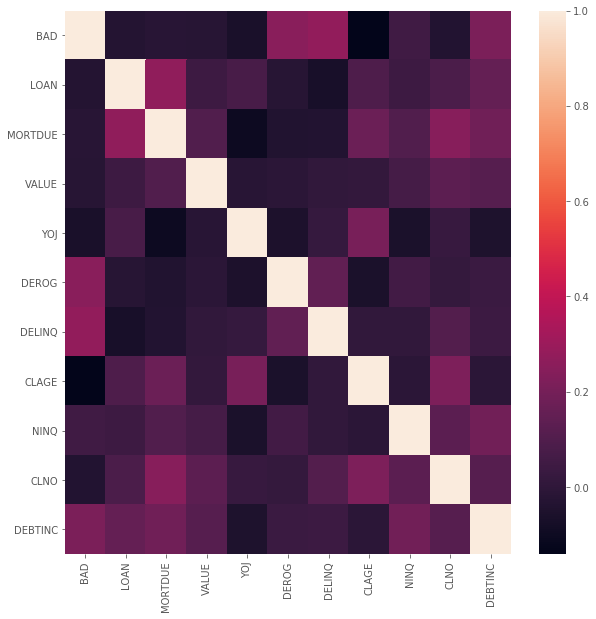

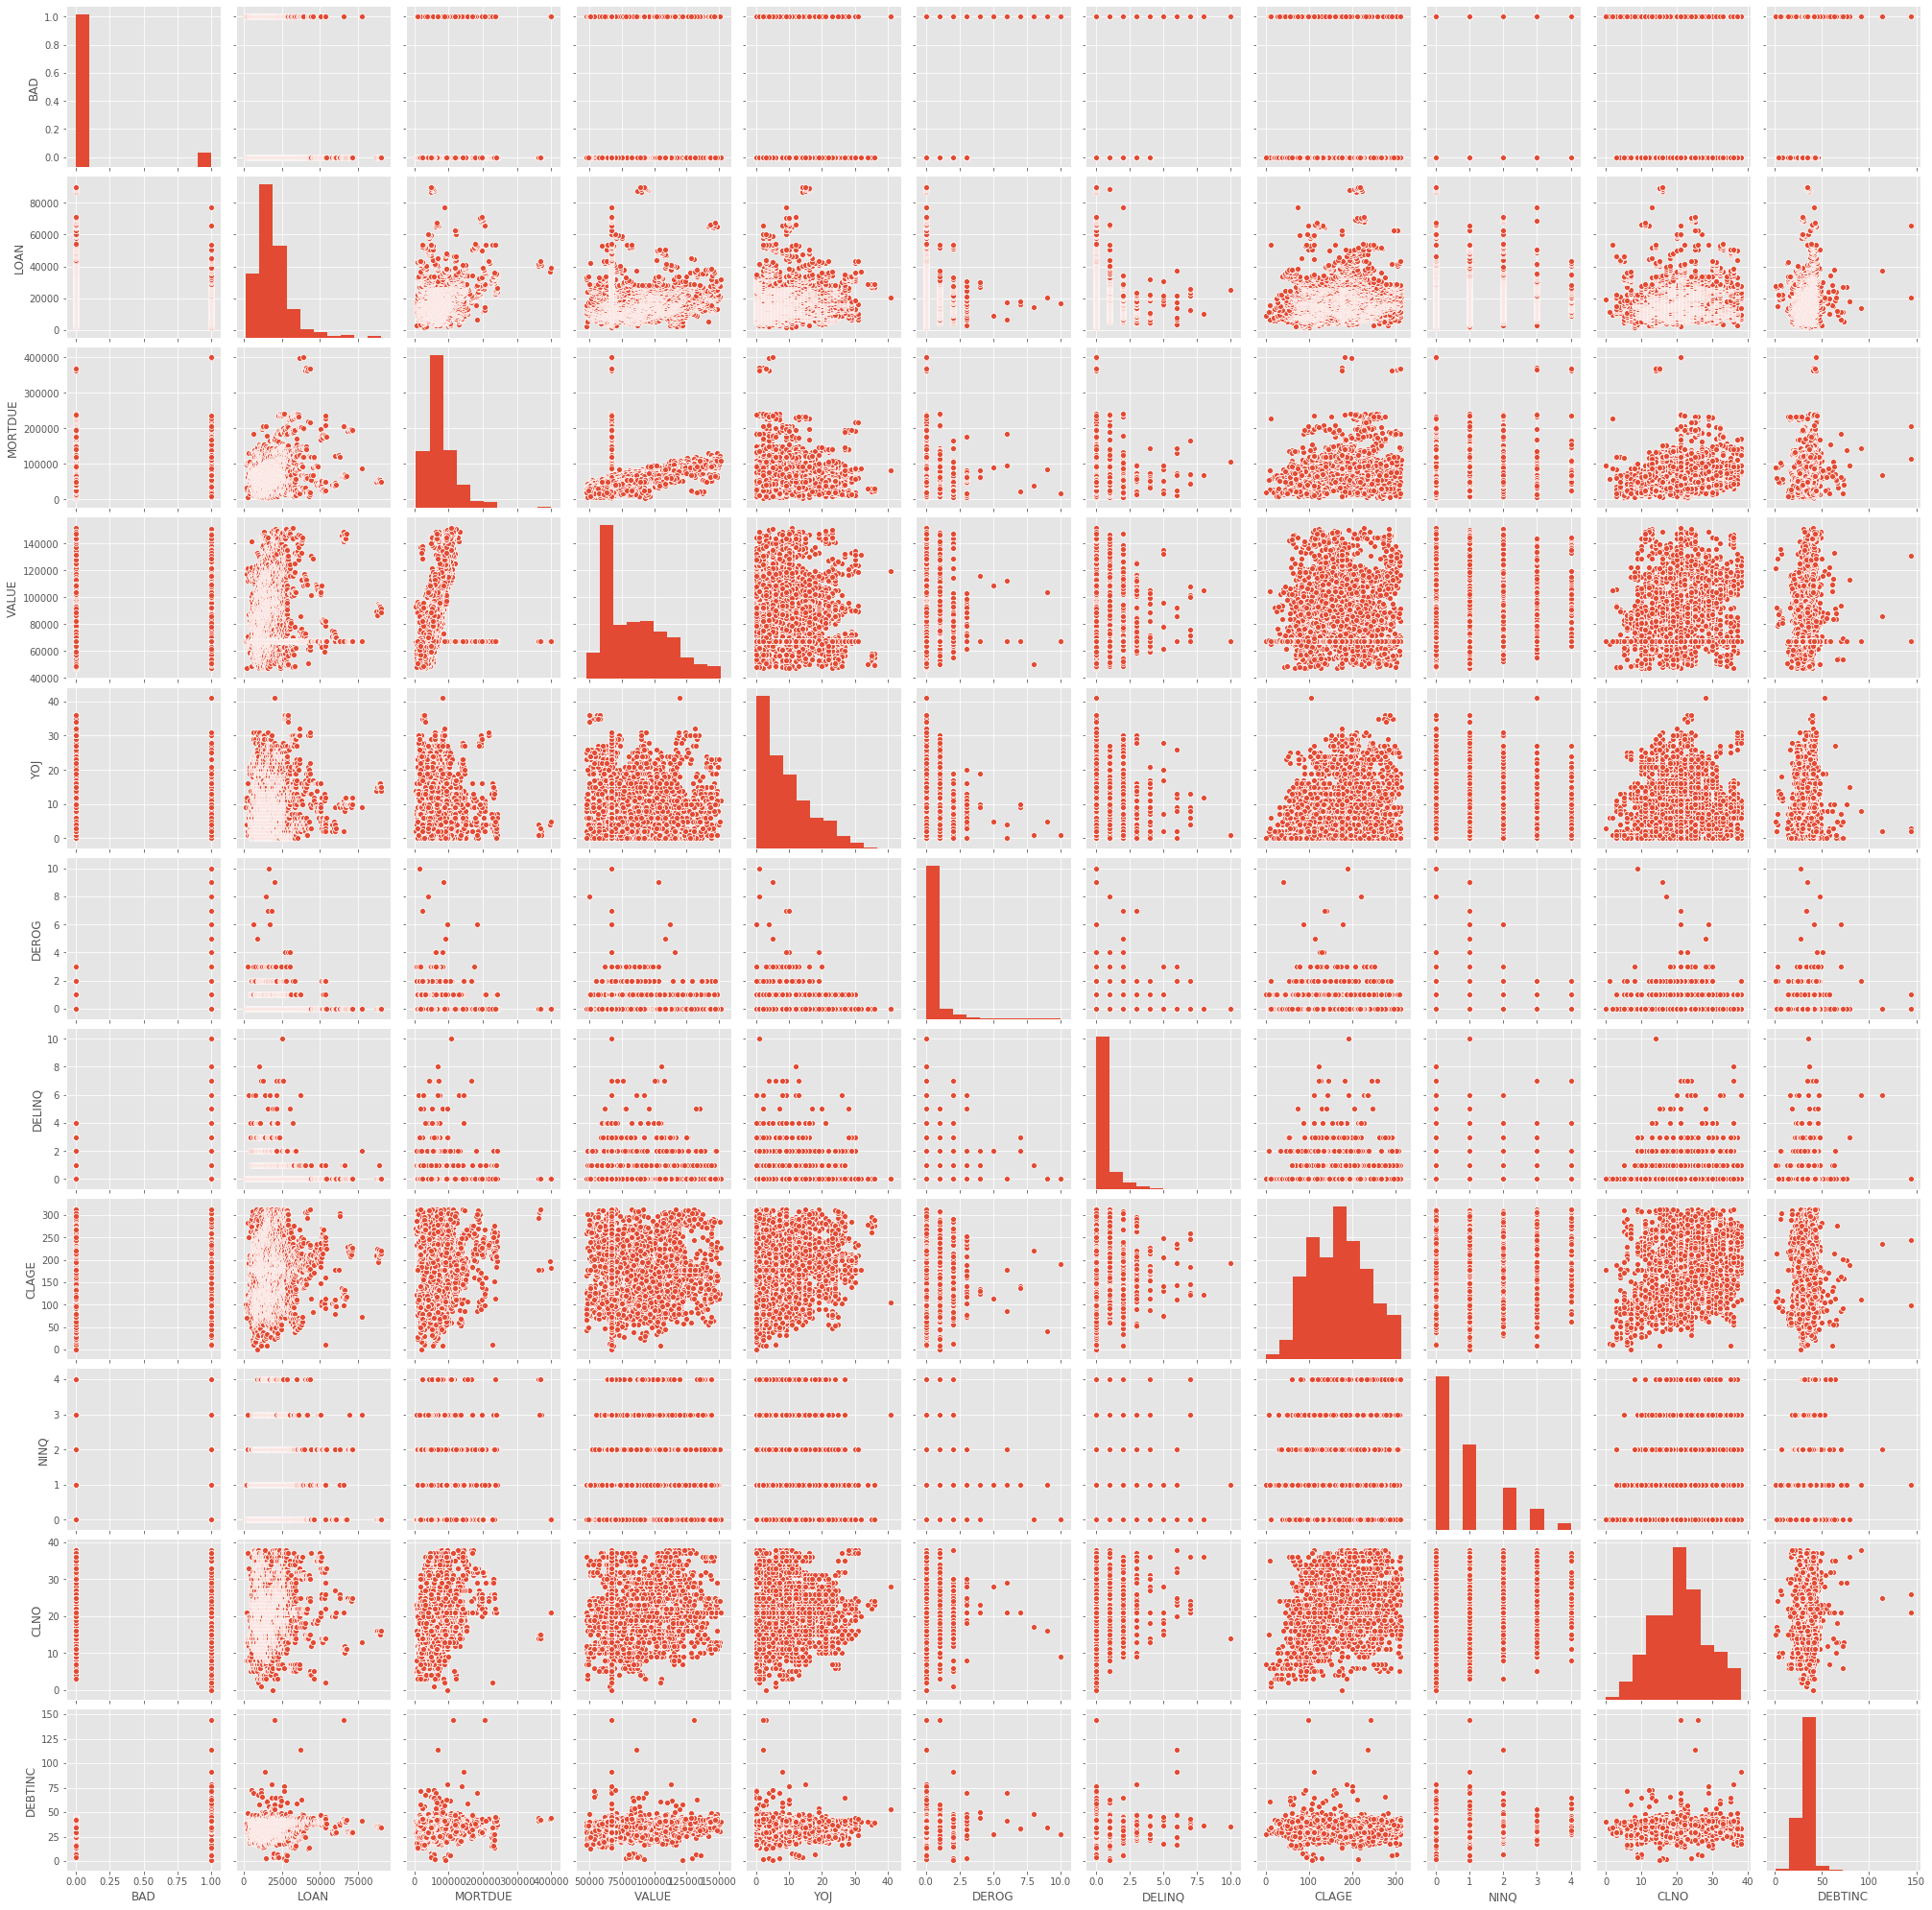

In [102]:
# Early visualizations
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
import sklearn
import sklearn.preprocessing

import os
os. getcwd()

print('plot inbound')
f, ax = plt.subplots(figsize=(10, 10))
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
# correlation matrix shows that strong positive correlations between BAD and DEROG, DELINQ, and DEBTINC

col_names = ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 
            'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']

    

df_pairplot = df.drop(['REASON', 'JOB'], axis = 1)
print(sns.pairplot(df_pairplot))
# the pairplot drops all categorical variables and only looks at the numerical columns
# it helps to visualzize relationships between 2 variables for all quantitative pairs
# this is great for illustrating many bivariate distributions
# LOOK FOR SCATTER PLOTS WITH CLEAR LINEAR PATTERNS TO DRAW INFERENCES



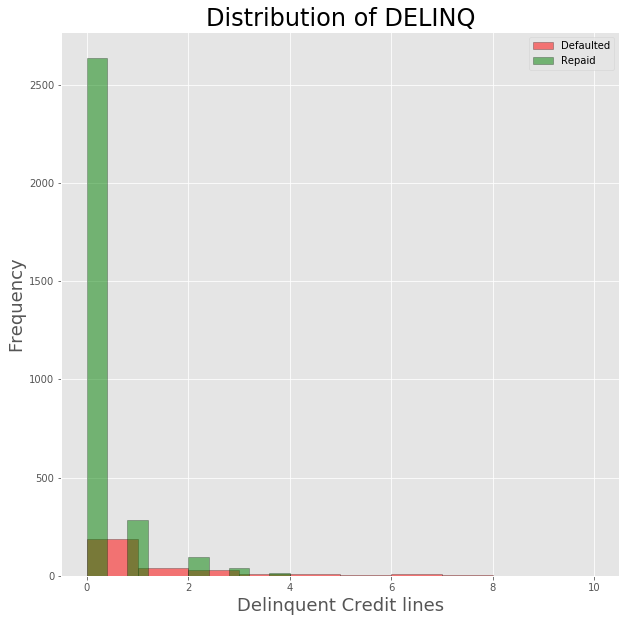

In [103]:
plt.style.use('ggplot')

df[df['BAD'] == 1].DELINQ.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].DELINQ.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of DELINQ', size=24)
plt.xlabel('Delinquent Credit lines', size=18)
plt.ylabel('Frequency', size=18);
# Taking proportion into account, more delinquent credit lines associates with defaults more often


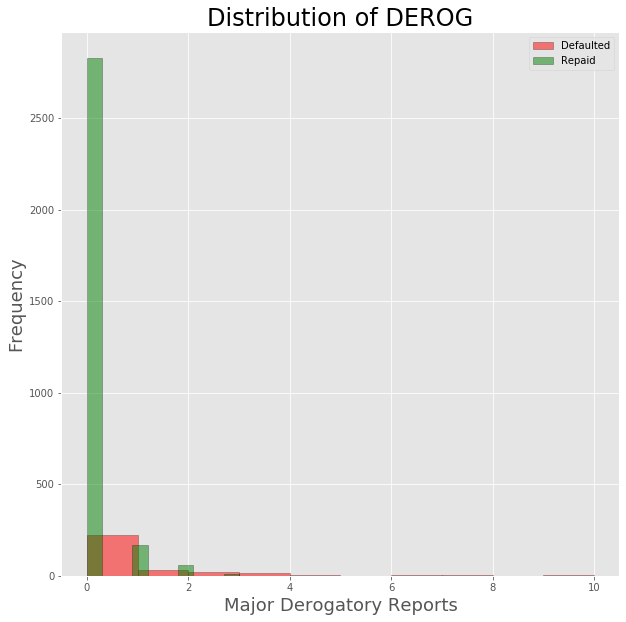

In [66]:
plt.style.use('ggplot')
df[df['BAD'] == 1].DEROG.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].DEROG.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of DEROG', size=24)
plt.xlabel('Major Derogatory Reports', size=18)
plt.ylabel('Frequency', size=18);
# Taking proportion into account, more derogatory reports associates with defaults more often


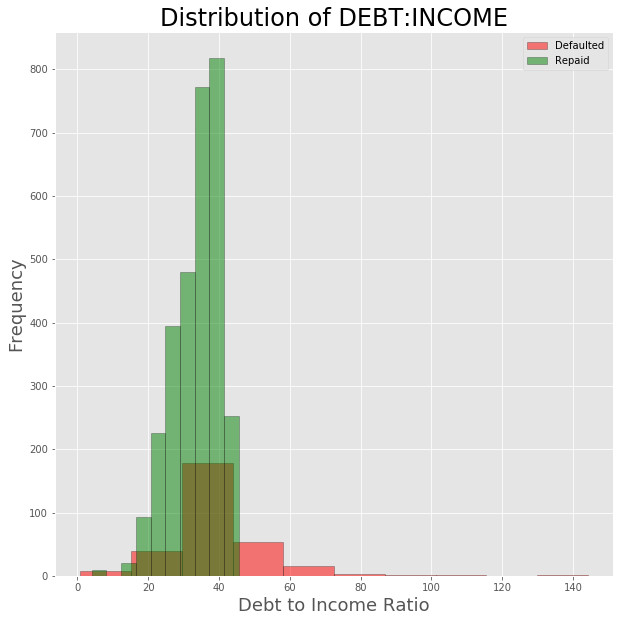

In [67]:
plt.style.use('ggplot')
df[df['BAD'] == 1].DEBTINC.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].DEBTINC.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of DEBT:INCOME', size=24)
plt.xlabel('Debt to Income Ratio', size=18)
plt.ylabel('Frequency', size=18);

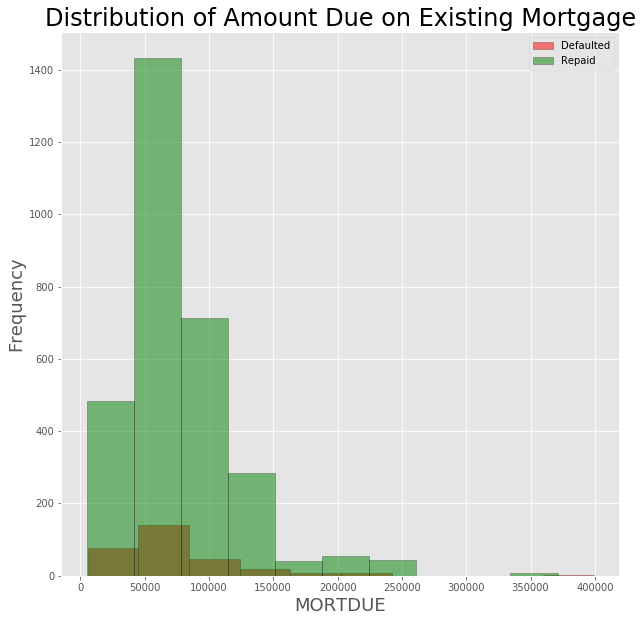

In [68]:
plt.style.use('ggplot')
df[df['BAD'] == 1].MORTDUE.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].MORTDUE.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of Amount Due on Existing Mortgage', size=24)
plt.xlabel('MORTDUE', size=18)
plt.ylabel('Frequency', size=18);

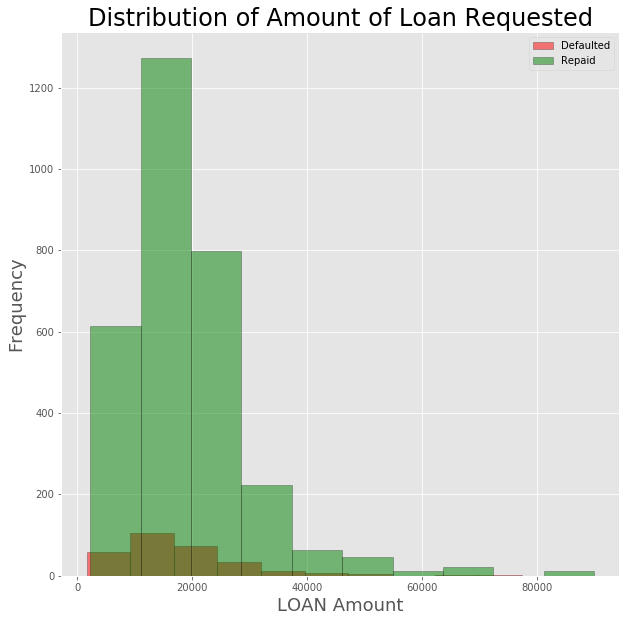

In [69]:
plt.style.use('ggplot')
df[df['BAD'] == 1].LOAN.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].LOAN.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of Amount of Loan Requested', size=24)
plt.xlabel('LOAN Amount', size=18)
plt.ylabel('Frequency', size=18);

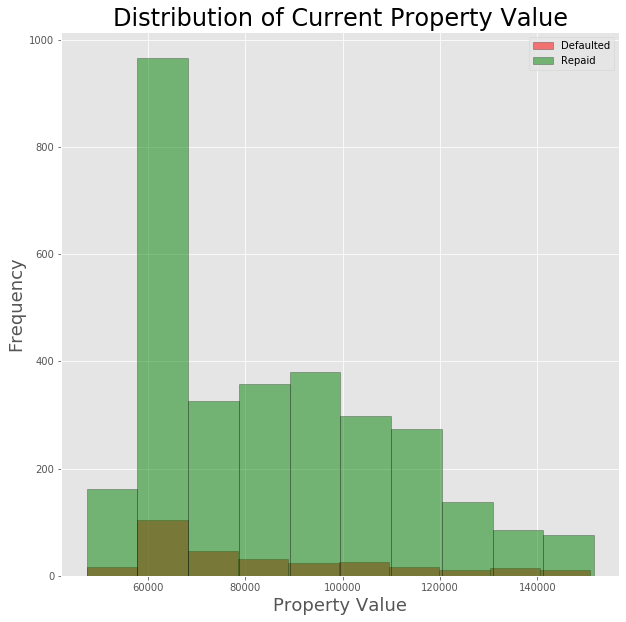

In [70]:
plt.style.use('ggplot')
df[df['BAD'] == 1].VALUE.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].VALUE.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of Current Property Value', size=24)
plt.xlabel('Property Value', size=18)
plt.ylabel('Frequency', size=18);

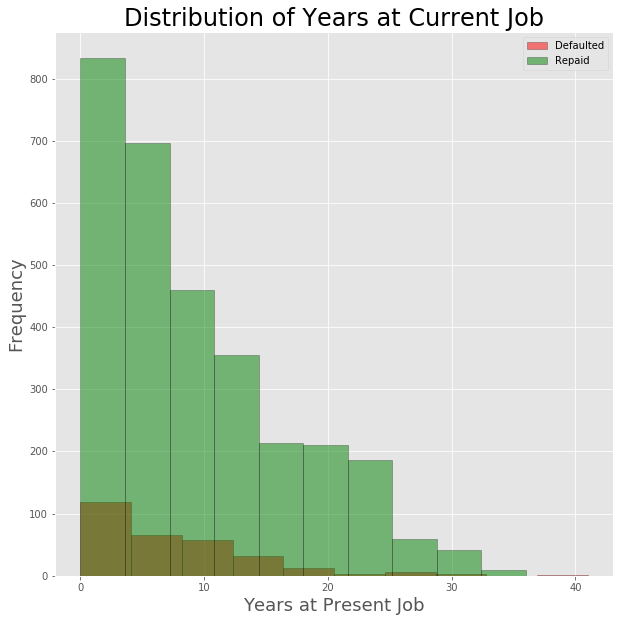

In [71]:
plt.style.use('ggplot')
df[df['BAD'] == 1].YOJ.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].YOJ.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of Years at Current Job', size=24)
plt.xlabel('Years at Present Job', size=18)
plt.ylabel('Frequency', size=18);

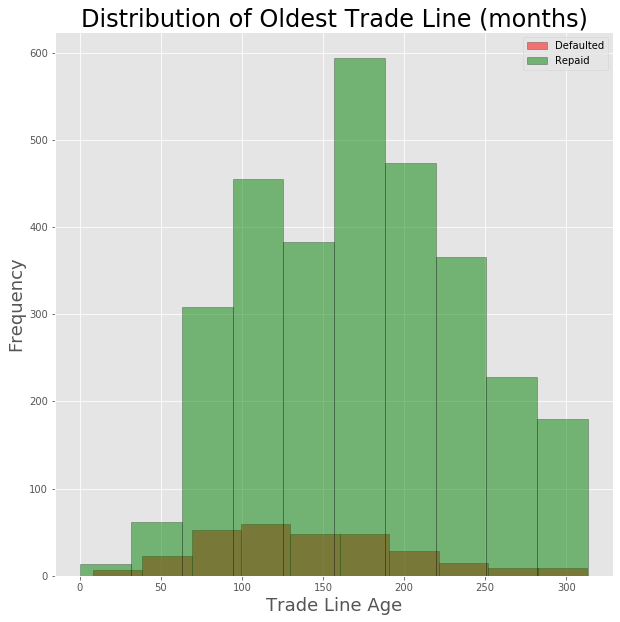

In [72]:
plt.style.use('ggplot')
df[df['BAD'] == 1].CLAGE.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].CLAGE.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of Oldest Trade Line (months)', size=24)
plt.xlabel('Trade Line Age', size=18)
plt.ylabel('Frequency', size=18);

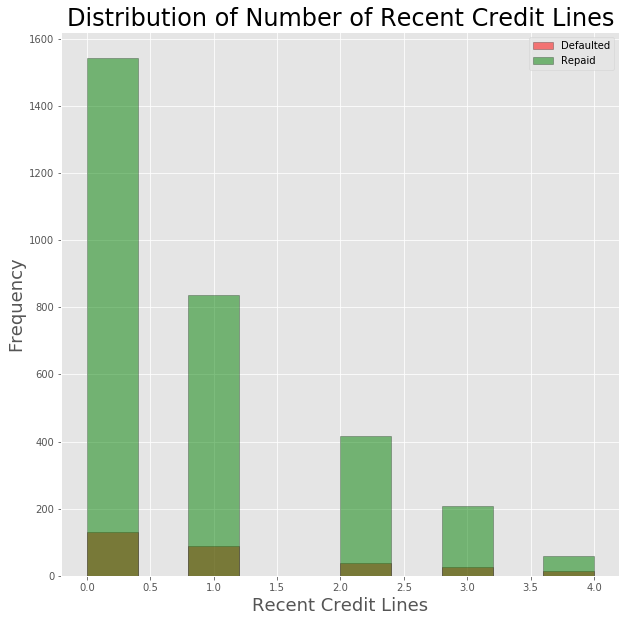

In [73]:
plt.style.use('ggplot')
df[df['BAD'] == 1].NINQ.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].NINQ.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of Number of Recent Credit Lines', size=24)
plt.xlabel('Recent Credit Lines', size=18)
plt.ylabel('Frequency', size=18);

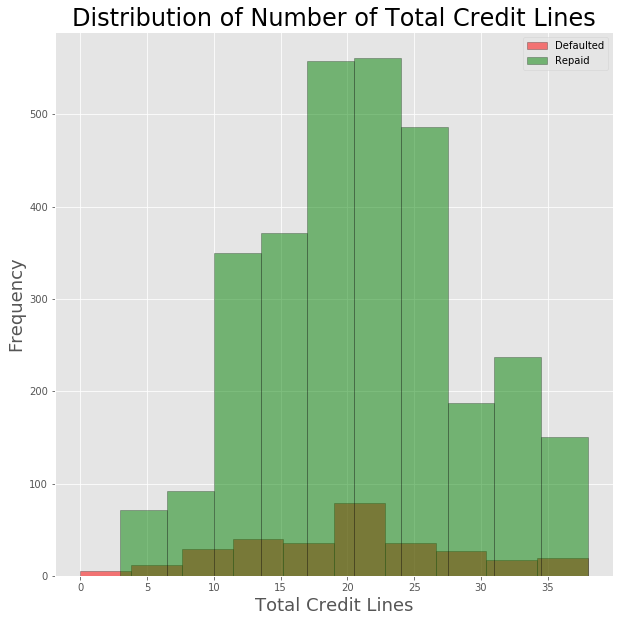

In [74]:
plt.style.use('ggplot')
df[df['BAD'] == 1].CLNO.plot(kind='hist', color='red', edgecolor='black', alpha=0.5, figsize=(10, 10))
df[df['BAD'] == 0].CLNO.plot(kind='hist', color='green', edgecolor='black', alpha=0.5, figsize=(10, 10))
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Distribution of Number of Total Credit Lines', size=24)
plt.xlabel('Total Credit Lines', size=18)
plt.ylabel('Frequency', size=18);

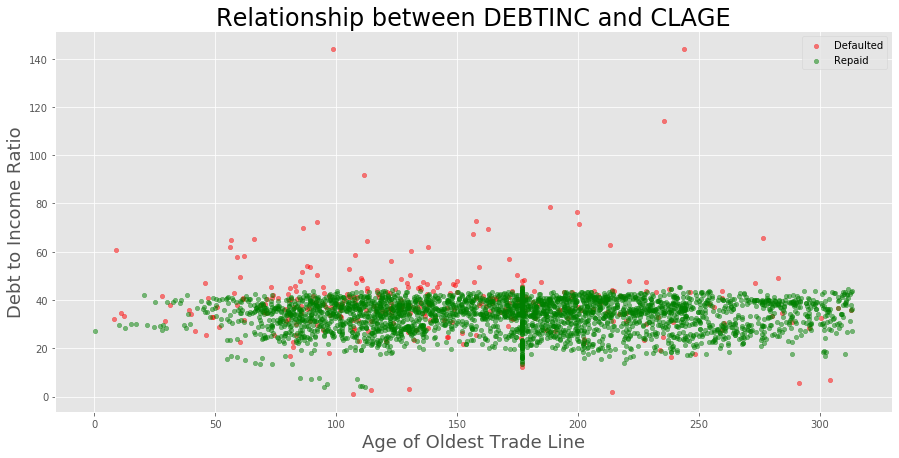

In [75]:
ax1 = df[df['BAD'] == 1].plot(kind='scatter', x='CLAGE', y='DEBTINC', color='red', alpha=0.5, figsize=(10, 7))
df[df['BAD'] == 0].plot(kind='scatter', x='CLAGE', y='DEBTINC', color='green', alpha=0.5, figsize=(15 ,7), ax=ax1)
plt.legend(labels=['Defaulted', 'Repaid'])
plt.title('Relationship between DEBTINC and CLAGE', size=24)
plt.ylabel('Debt to Income Ratio', size=18)
plt.xlabel('Age of Oldest Trade Line', size=18);




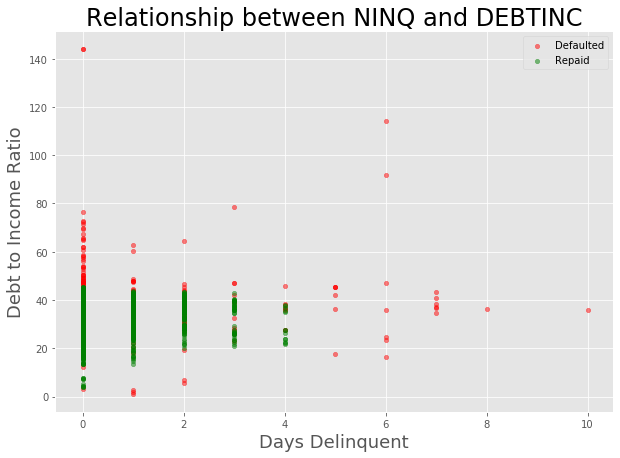

In [76]:
ax1 = df[df['BAD'] == 1].plot(kind='scatter', x='DELINQ', y='DEBTINC', color='red', alpha=0.5, figsize=(10, 7))
df[df['BAD'] == 0].plot(kind='scatter', x='DELINQ', y='DEBTINC', color='green', alpha=0.5, figsize=(10 ,7), ax=ax1)
plt.legend(labels=['Defaulted','Repaid'])
plt.title('Relationship between NINQ and DEBTINC', size=24)
plt.xlabel('Days Delinquent', size=18)
plt.ylabel('Debt to Income Ratio', size=18);

# illustrates the importance of debt to income ratio and not as straightforward portant, but DEROG too

In [104]:
# Multiple Linear Regression Analysis
# Problem Framing

# turn categorical variables into dummy variables for regression analysis
dummy_REASON = pd.get_dummies(df['REASON'])
dummy_JOB = pd.get_dummies(df['JOB'])

dummy_REASON.head()
dummy_JOB.head()

df = pd.concat([df, dummy_REASON], axis=1)
df = pd.concat([df, dummy_JOB], axis=1)


print(dummy_REASON)
print(dummy_JOB)
print(df) # too many columns (21), must drop the old categorical and store in a new dataframe for the regression analysis purposes

df.drop('REASON', axis=1, inplace=True)
df.drop('JOB', axis=1, inplace=True)
print(df) # now only has 19 columns which is perfect to move forward with
# must assess multicollinearity though and create a new dataframe for the regression analysis








      DebtCon  HomeImp
5           0        1
7           0        1
19          0        1
25          0        1
26          0        1
...       ...      ...
5955        1        0
5956        1        0
5957        1        0
5958        1        0
5959        1        0

[3364 rows x 2 columns]
      Mgr  Office  Other  ProfExe  Sales  Self
5       0       0      1        0      0     0
7       0       0      1        0      0     0
19      0       1      0        0      0     0
25      1       0      0        0      0     0
26      0       1      0        0      0     0
...   ...     ...    ...      ...    ...   ...
5955    0       0      1        0      0     0
5956    0       0      1        0      0     0
5957    0       0      1        0      0     0
5958    0       0      1        0      0     0
5959    0       0      1        0      0     0

[3364 rows x 6 columns]
      BAD   LOAN   MORTDUE     VALUE   REASON     JOB   YOJ  DEROG  DELINQ  \
5       1   1700   30548.0   672

In [105]:
# Must avoid multi-collinearity so one of each categorical dummy must be dropped since that will be captured in the intercept value

dfreg = DataFrame(df)
# drop REASON HomeImp column
dfreg.drop('HomeImp', axis=1, inplace=True)

# df_dummy dataframe first 5 columns
dfreg.head()

dfreg.drop('Self', axis=1, inplace=True)

# df_dummy dataframe first 5 columns
dfreg.head()

print(dfreg)

dfreg.groupby('BAD').mean()


      BAD   LOAN   MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  \
5       1   1700   30548.0   67278.5   9.0    0.0     0.0  101.466002   1.0   
7       1   1800   28502.0   67278.5  11.0    0.0     0.0   88.766030   0.0   
19      0   2300  102370.0  120953.0   2.0    0.0     0.0   90.992533   0.0   
25      1   2400   34863.0   47471.0  12.0    0.0     0.0   70.491080   1.0   
26      0   2400   98449.0  117195.0   4.0    0.0     0.0   93.811775   0.0   
...   ...    ...       ...       ...   ...    ...     ...         ...   ...   
5955    0  88900   57264.0   90185.0  16.0    0.0     0.0  221.808717   0.0   
5956    0  89000   54576.0   92937.0  16.0    0.0     0.0  208.692070   0.0   
5957    0  89200   54045.0   92924.0  15.0    0.0     0.0  212.279697   0.0   
5958    0  89800   50370.0   91861.0  14.0    0.0     0.0  213.892709   0.0   
5959    0  89900   48811.0   88934.0  15.0    0.0     0.0  219.601002   0.0   

      CLNO    DEBTINC  DebtCon  Mgr  Office  Other 

,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,DebtCon,Mgr,Office,Other,ProfExe,Sales
BAD,,,,,,,,,,,,,,,,
0,19260.607050,76483.152742,86345.983518,9.263055,0.100849,0.209204,173.815494,0.82735,20.964099,33.595725,0.703329,0.13218,0.175914,0.376632,0.274478,0.012728
1,18069.666667,73864.490000,84535.955000,7.550000,0.616667,0.990000,141.622466,1.02000,19.953333,39.647852,0.713333,0.15000,0.126667,0.440000,0.193333,0.046667


plot inbound


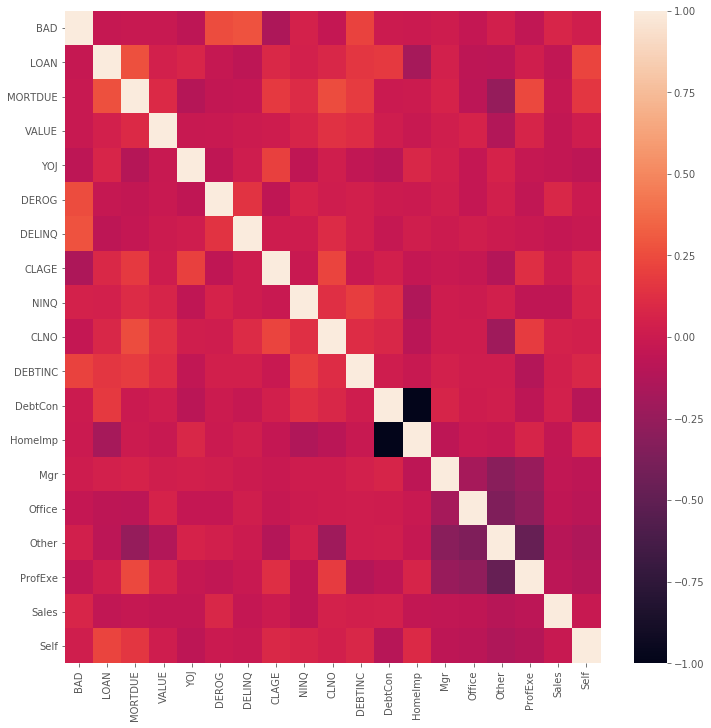

In [106]:
# df_dummy dataframe first 5 columns
df.head()

#print(df) # now only has 17 rows which is perfect in this temp dataframe for regression

import matplotlib.pyplot as plt
print('plot inbound')
f, ax = plt.subplots(figsize=(12, 12))
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
# correlation matrix shows that strong positive correlations between BAD and DEROG, DELINQ, and DEBTINC

col_names = ['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 
            'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'DebtCon',
            'Mgr', 'Office', 'Other', 'ProfExe', 'Sales']


# Matrix shows BAD strongly correlated with: DEROG, DELINQ, DEBTINC
# ........Also some corr to Other, Sales, Mgr, NINQ, DebtCon

In [107]:
from sklearn.linear_model import LinearRegression

# create multiple linear regression object
mlr = LinearRegression()

# fit linear regression
mlr.fit(dfreg[['LOAN', 'MORTDUE','VALUE', 'YOJ','DEROG', 'DELINQ',
              'CLAGE', 'NINQ','CLNO', 'DEBTINC','DebtCon', 'Mgr',
              'Office', 'Other','ProfExe', 'Sales']], dfreg['BAD'])

# get the slope and intercept of the line best fit.
print('Intercept: ',mlr.intercept_)

print('Coefficients: ',mlr.coef_)

names = [i for i in list(dfreg)] # list of column names
print(names)


mlr.coef_[0].tolist() #BAD
 


#print('LOAN: -9.59550571e-07')

#print('MORTDUE':)'MORTDUE','VALUE', 'YOJ','DEROG', 'DELINQ',
#             'CLAGE', 'NINQ','CLNO', 'DEBTINC','DebtCon', 'Mgr',
#              'Office', 'Other','ProfExe', 'Sales')

Intercept:  0.03843554574846872
Coefficients:  [-9.59550571e-07 -8.81731489e-09 -3.79345296e-07 -4.74296226e-04
  9.64628369e-02  8.75886519e-02 -5.06037261e-04  2.57472464e-03
 -2.65092241e-03  7.57200423e-03  1.52417003e-02 -6.05766877e-02
 -9.02844152e-02 -6.45366446e-02 -5.35872834e-02  8.00547034e-02]
['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'DebtCon', 'Mgr', 'Office', 'Other', 'ProfExe', 'Sales']


-9.59550570612371e-07

In [108]:
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Separate input features and output from dfreg dataset
X = dfreg.iloc[:,dfreg.columns != 'BAD']
Y = dfreg.iloc[:,0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state= 0)
# In the train_test_split function, I made a test size of .3 (30% of the data for testing and 70% for training)


In [109]:
# Now time to train the model
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

# Find the coefficient values for predicting BAD (y-variable)
coeff_df = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
intercept_df = pd.DataFrame(model.inter)
print(coeff_df)




AttributeError: 'LinearRegression' object has no attribute 'inter'

In [110]:
# Output prediction
y_pred = model.predict(X_test)
dfreg_0 = pd.DataFrame({'Actual': Y_test, 'Predicted': y_pred})
print(dfreg_0.tail(10))


      Actual  Predicted
3355       0  -0.080687
3573       1   0.175857
1840       0   0.303457
2015       0   0.188410
2834       0   0.245880
5282       1   0.754671
3508       0   0.047520
1356       0   0.238526
3704       0   0.066681
1969       0   0.053162


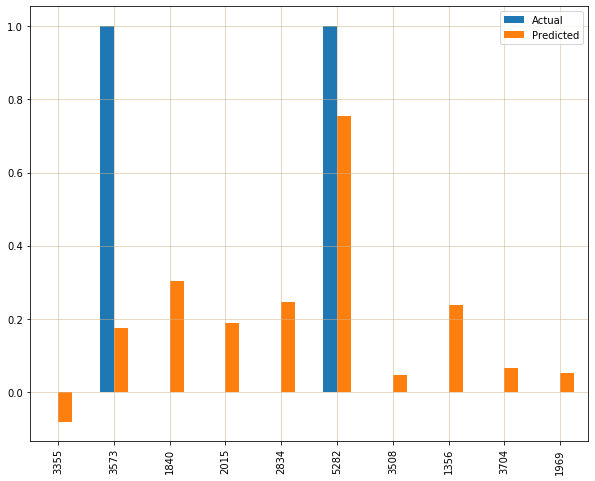

In [12]:
# How accurate are the predictions in this model??
accuracyPlotTail10 = DataFrame(dfreg_0.tail(10))
accuracyPlotTail10.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='tan')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# This shows just the tail 10 in the dataframe and you can see some are not great predictions


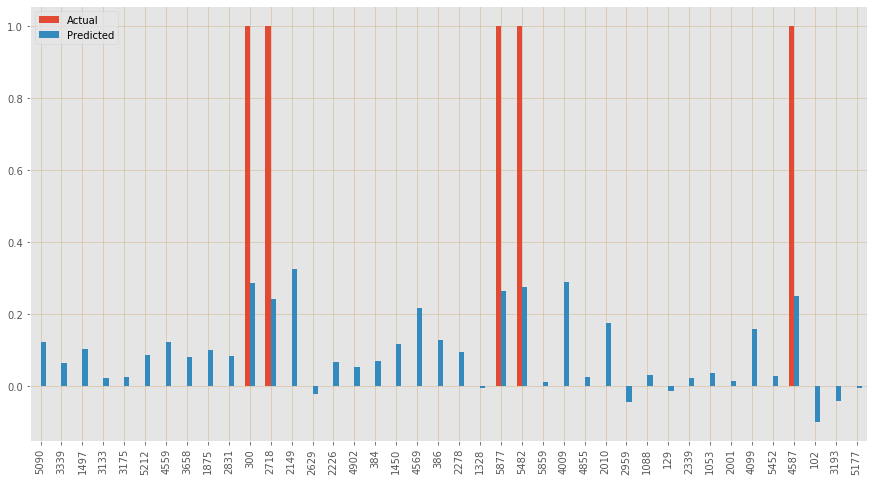

In [84]:
# How accurate are the predictions in this model??
accuracyPlotHead40 = DataFrame(dfreg_0.head(40))
accuracyPlotHead40.plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='tan')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
# this shows a bit more of a trend where we can understand the predictions and take them for some accuracy but not completely

# It is defintely better to have a prediction that looks like BAD = 1 (defaulted loan) but is actually BAD = 0 (repaid loan)...
#   ....than a prediction that is BAD = 0 but actually is BAD = 1 because this second option is where a lot of money is lost

# After looking at this graph of the first 40 rows, a cutoff of .2 looks like it could indicate when to accept a loan

# Anyone below .2 is approved for the loan and anyone over .2 is rejected. Not 100% accurate, but safe from a risk purpose standpoint and still allots for giving out many loans






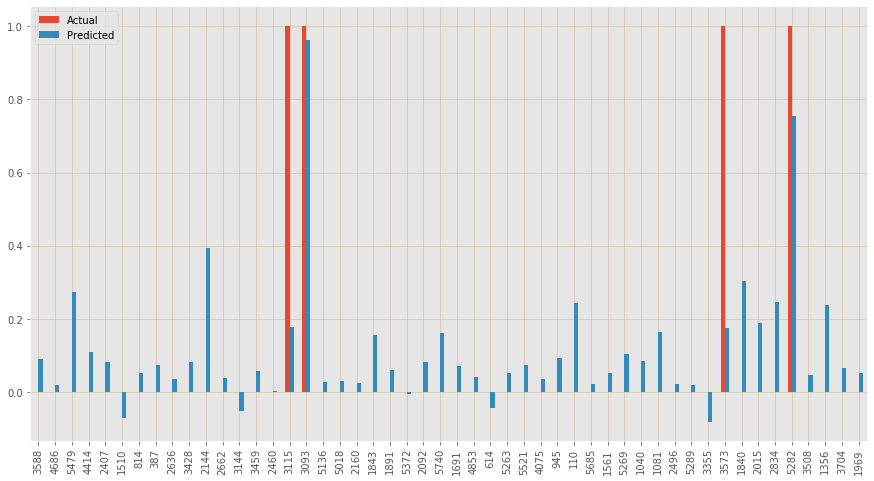

In [85]:
# I want to check on the last 40 rows as well to see if this assumption still looks safe and prudent
accuracyPlotTail50 = DataFrame(dfreg_0.tail(50))
accuracyPlotTail50.plot(kind='bar',figsize=(15,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='tan')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# This plot now contradicts what my prior assumption was

# There are two costly predictions (3115 and 3573) that are predicted under y-hat = .2, but actually are defaulted loans




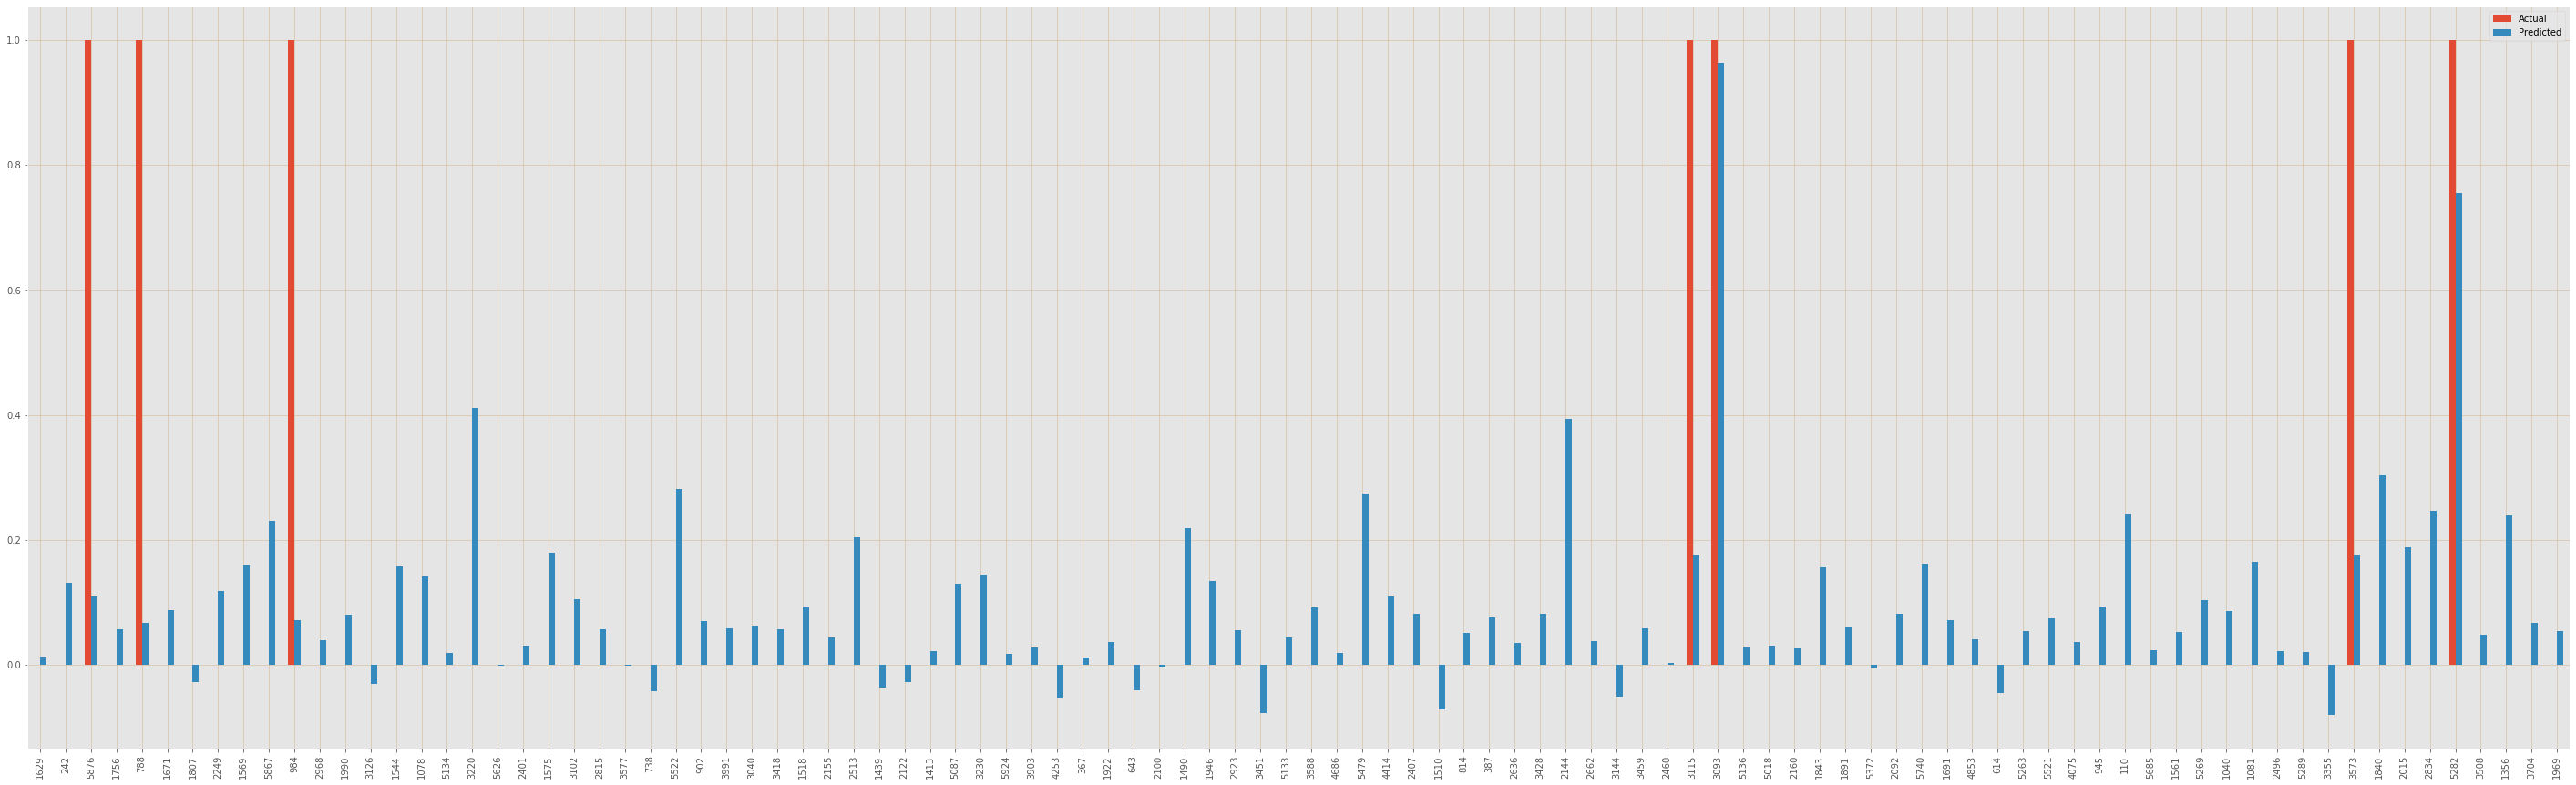

In [86]:
# I want to check on the last 100 rows now
accuracyPlotTail100 = DataFrame(dfreg_0.tail(100))
accuracyPlotTail100.plot(kind='bar',figsize=(50,15))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='tan')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# after doing this for the tail 100 rows it is clear the original .2 cutoff assumption was a bad one

# 5 of the 7 actual BAD = 1 (defaulted) are below the .2 cutoff point, which is about 29% accuracy...VERY BAD




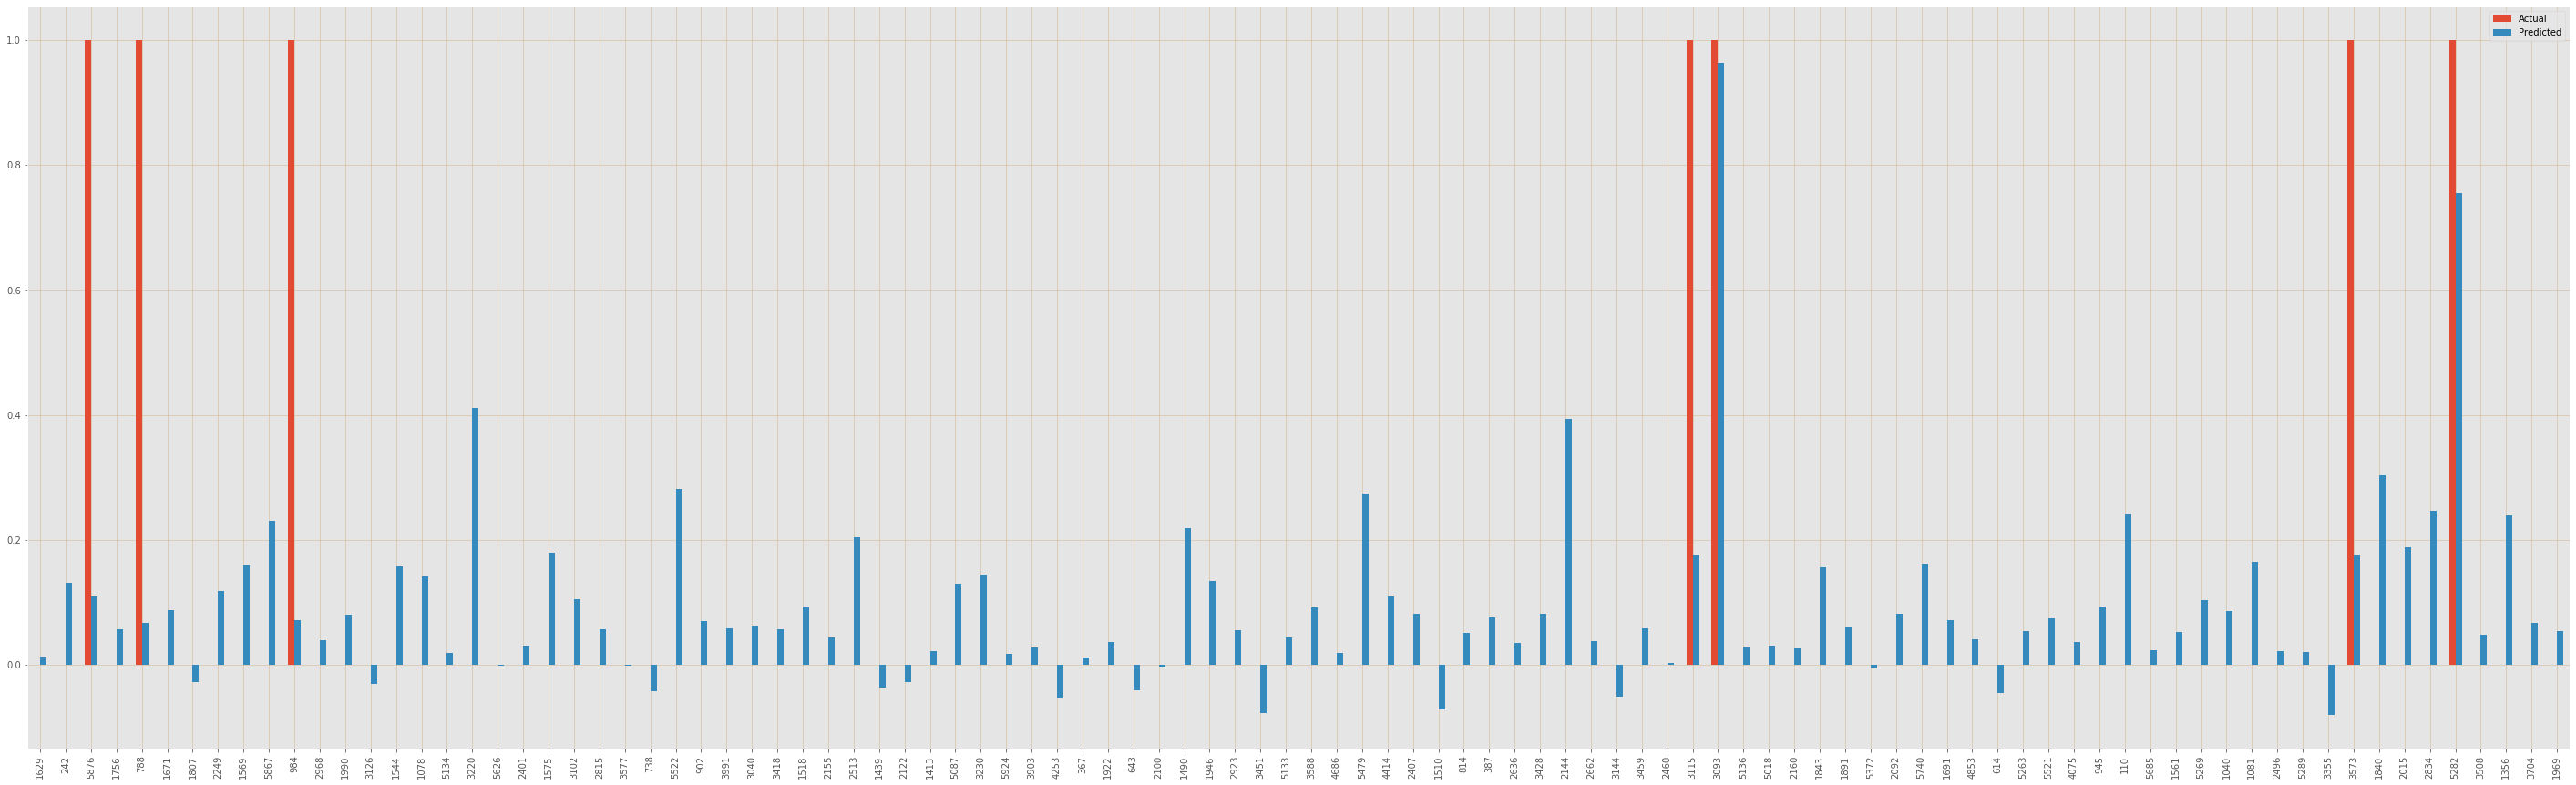

10

In [87]:
# I want to check on the first 100 rows now
accuracyPlotHead100 = DataFrame(dfreg_0.head(100))
accuracyPlotTail100.plot(kind='bar',figsize=(50,15))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='tan')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

# However,  blowing up the first 100 rows makes the accuracy rate for this assumption 89%


# Combining these two rates
7+9 #16
8+2 #10
# Combined Accuracy = 62.5%
# I think this can definitely be improved upon, especially considering this still is accounting for incorrect BAD = 0 prediction at the .2 cutoff

# Next step is to weed out less predictive coefficient variables



In [111]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
print(dfreg)
# A are the explanatory variables
A = DataFrame(dfreg)
A.drop('BAD', axis=1, inplace=True)

# B is the y - variable I am trying the predict (BAD)
B = DataFrame(dfreg)
B.drop('LOAN', axis=1, inplace=True)
B.drop('MORTDUE', axis=1, inplace=True)
B.drop('VALUE', axis=1, inplace=True)
B.drop('YOJ', axis=1, inplace=True)
B.drop('DEROG', axis=1, inplace=True)
B.drop('DELINQ', axis=1, inplace=True)
B.drop('CLAGE', axis=1, inplace=True)
B.drop('NINQ', axis=1, inplace=True)
B.drop('CLNO', axis=1, inplace=True)
B.drop('DEBTINC', axis=1, inplace=True)
B.drop('DebtCon', axis=1, inplace=True)
B.drop('Mgr', axis=1, inplace=True)
B.drop('Office', axis=1, inplace=True)
B.drop('Other', axis=1, inplace=True)
B.drop('ProfExe', axis=1, inplace=True)
B.drop('Sales', axis=1, inplace=True)

X = A
y = B

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

# Stepwise Regression

      BAD   LOAN   MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  \
5       1   1700   30548.0   67278.5   9.0    0.0     0.0  101.466002   1.0   
7       1   1800   28502.0   67278.5  11.0    0.0     0.0   88.766030   0.0   
19      0   2300  102370.0  120953.0   2.0    0.0     0.0   90.992533   0.0   
25      1   2400   34863.0   47471.0  12.0    0.0     0.0   70.491080   1.0   
26      0   2400   98449.0  117195.0   4.0    0.0     0.0   93.811775   0.0   
...   ...    ...       ...       ...   ...    ...     ...         ...   ...   
5955    0  88900   57264.0   90185.0  16.0    0.0     0.0  221.808717   0.0   
5956    0  89000   54576.0   92937.0  16.0    0.0     0.0  208.692070   0.0   
5957    0  89200   54045.0   92924.0  15.0    0.0     0.0  212.279697   0.0   
5958    0  89800   50370.0   91861.0  14.0    0.0     0.0  213.892709   0.0   
5959    0  89900   48811.0   88934.0  15.0    0.0     0.0  219.601002   0.0   

      CLNO    DEBTINC  DebtCon  Mgr  Office  Other 

In [89]:
# Stepwise Regression Step 1 
## I will remove worst/highest P-value until Adj. R^2 decreases from previous step

# REMOVE MORTDUE

# A are the explanatory variables
A = DataFrame(dfreg)
A.drop('BAD', axis=1, inplace=True)
A.drop('MORTDUE', axis=1, inplace=True)

# B is the y - variable I am trying the predict (BAD)
B = DataFrame(dfreg)
B.drop('LOAN', axis=1, inplace=True)
B.drop('MORTDUE', axis=1, inplace=True)
B.drop('VALUE', axis=1, inplace=True)
B.drop('YOJ', axis=1, inplace=True)
B.drop('DEROG', axis=1, inplace=True)
B.drop('DELINQ', axis=1, inplace=True)
B.drop('CLAGE', axis=1, inplace=True)
B.drop('NINQ', axis=1, inplace=True)
B.drop('CLNO', axis=1, inplace=True)
B.drop('DEBTINC', axis=1, inplace=True)
B.drop('DebtCon', axis=1, inplace=True)
B.drop('Mgr', axis=1, inplace=True)
B.drop('Office', axis=1, inplace=True)
B.drop('Other', axis=1, inplace=True)
B.drop('ProfExe', axis=1, inplace=True)
B.drop('Sales', axis=1, inplace=True)

X = A
y = B

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())



                            OLS Regression Results                            
Dep. Variable:                    BAD   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     53.24
Date:                Fri, 03 Jul 2020   Prob (F-statistic):          3.27e-143
Time:                        21:54:12   Log-Likelihood:                -190.79
No. Observations:                3364   AIC:                             413.6
Df Residuals:                    3348   BIC:                             511.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0382      0.041      0.937      0.3

In [90]:
# Stepwise Regression Step 2
## I will remove worst/highest P-value until Adj. R^2 decreases from previous step

## REMOVE NINQ

# A are the explanatory variables
A = DataFrame(dfreg)
A.drop('BAD', axis=1, inplace=True)
A.drop('MORTDUE', axis=1, inplace=True)
A.drop('NINQ', axis=1, inplace=True)


# B is the y - variable I am trying the predict (BAD)
B = DataFrame(dfreg)
B.drop('LOAN', axis=1, inplace=True)
B.drop('MORTDUE', axis=1, inplace=True)
B.drop('VALUE', axis=1, inplace=True)
B.drop('YOJ', axis=1, inplace=True)
B.drop('DEROG', axis=1, inplace=True)
B.drop('DELINQ', axis=1, inplace=True)
B.drop('CLAGE', axis=1, inplace=True)
B.drop('NINQ', axis=1, inplace=True)
B.drop('CLNO', axis=1, inplace=True)
B.drop('DEBTINC', axis=1, inplace=True)
B.drop('DebtCon', axis=1, inplace=True)
B.drop('Mgr', axis=1, inplace=True)
B.drop('Office', axis=1, inplace=True)
B.drop('Other', axis=1, inplace=True)
B.drop('ProfExe', axis=1, inplace=True)
B.drop('Sales', axis=1, inplace=True)

X = A
y = B

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())



                            OLS Regression Results                            
Dep. Variable:                    BAD   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     57.03
Date:                Fri, 03 Jul 2020   Prob (F-statistic):          5.00e-144
Time:                        21:55:31   Log-Likelihood:                -190.96
No. Observations:                3364   AIC:                             411.9
Df Residuals:                    3349   BIC:                             503.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0381      0.041      0.935      0.3

In [91]:
# Stepwise Regression Step 3
## I will remove worst/highest P-value until Adj. R^2 decreases from previous step

## REMOVE YOJ

# A are the explanatory variables
A = DataFrame(dfreg)
A.drop('BAD', axis=1, inplace=True)
A.drop('MORTDUE', axis=1, inplace=True)
A.drop('NINQ', axis=1, inplace=True)
A.drop('YOJ', axis=1, inplace=True)



# B is the y - variable I am trying the predict (BAD)
B = DataFrame(dfreg)
B.drop('LOAN', axis=1, inplace=True)
B.drop('MORTDUE', axis=1, inplace=True)
B.drop('VALUE', axis=1, inplace=True)
B.drop('YOJ', axis=1, inplace=True)
B.drop('DEROG', axis=1, inplace=True)
B.drop('DELINQ', axis=1, inplace=True)
B.drop('CLAGE', axis=1, inplace=True)
B.drop('NINQ', axis=1, inplace=True)
B.drop('CLNO', axis=1, inplace=True)
B.drop('DEBTINC', axis=1, inplace=True)
B.drop('DebtCon', axis=1, inplace=True)
B.drop('Mgr', axis=1, inplace=True)
B.drop('Office', axis=1, inplace=True)
B.drop('Other', axis=1, inplace=True)
B.drop('ProfExe', axis=1, inplace=True)
B.drop('Sales', axis=1, inplace=True)

X = A
y = B

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())



                            OLS Regression Results                            
Dep. Variable:                    BAD   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     61.38
Date:                Fri, 03 Jul 2020   Prob (F-statistic):          8.48e-145
Time:                        21:55:35   Log-Likelihood:                -191.27
No. Observations:                3364   AIC:                             410.5
Df Residuals:                    3350   BIC:                             496.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0375      0.041      0.919      0.3

In [92]:
# Stepwise Regression Step 4
## I will remove worst/highest P-value until Adj. R^2 decreases from previous step

## REMOVE Sales

# A are the explanatory variables
A = DataFrame(dfreg)
A.drop('BAD', axis=1, inplace=True)
A.drop('MORTDUE', axis=1, inplace=True)
A.drop('NINQ', axis=1, inplace=True)
A.drop('YOJ', axis=1, inplace=True)
A.drop('Sales', axis=1, inplace=True)




# B is the y - variable I am trying the predict (BAD)
B = DataFrame(dfreg)
B.drop('LOAN', axis=1, inplace=True)
B.drop('MORTDUE', axis=1, inplace=True)
B.drop('VALUE', axis=1, inplace=True)
B.drop('YOJ', axis=1, inplace=True)
B.drop('DEROG', axis=1, inplace=True)
B.drop('DELINQ', axis=1, inplace=True)
B.drop('CLAGE', axis=1, inplace=True)
B.drop('NINQ', axis=1, inplace=True)
B.drop('CLNO', axis=1, inplace=True)
B.drop('DEBTINC', axis=1, inplace=True)
B.drop('DebtCon', axis=1, inplace=True)
B.drop('Mgr', axis=1, inplace=True)
B.drop('Office', axis=1, inplace=True)
B.drop('Other', axis=1, inplace=True)
B.drop('ProfExe', axis=1, inplace=True)
B.drop('Sales', axis=1, inplace=True)

X = A
y = B

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())


# At this point I realize that Adj. R^2 does not move when it theoretically should
# I think this is due to the discrete numerical nature of my dependent variable
# I am going to now pivot to a logistic regression model 

                            OLS Regression Results                            
Dep. Variable:                    BAD   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     66.22
Date:                Fri, 03 Jul 2020   Prob (F-statistic):          4.17e-145
Time:                        21:55:46   Log-Likelihood:                -192.70
No. Observations:                3364   AIC:                             411.4
Df Residuals:                    3351   BIC:                             491.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0674      0.037      1.834      0.0

In [112]:
# FIRST ATTEMPT AT SAMPLE IMBALANCE AND MULT LOG REGRESSION (BAD ACCURACY OUTCOME, GOOD IMBALANCE MITIGATION)
# Up Sampling the Minority Class to Avoid Imbalances in samples


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Train model 1
y = dfreg.BAD
X = dfreg.drop('BAD', axis=1)
clf_0 = LogisticRegression().fit(X, y)
pred_y_0 = clf_0.predict(X)
print( accuracy_score(pred_y_0, y) ) #91.5% accuracy is not actually true because of imbalanced data
# The issue is that we have to increase the minority sample
from sklearn.utils import resample

# Separate majority and minority classes
dfreg_majority = dfreg[dfreg.BAD==0]
dfreg_minority = dfreg[dfreg.BAD==1]

dfreg['BAD'].value_counts() # 3064 in majority class

# Upsample minority class
dfreg_minority_upsampled = resample(dfreg_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=3064,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
dfreg_upsampled = pd.concat([dfreg_majority, dfreg_minority_upsampled])

# Display new class counts
print('Balanced samples:')
print(dfreg_upsampled.BAD.value_counts())
# 1    3064
# 0    3064
    

    
# Train model 2
# Separate input variables (X) and target variable (y)
y = dfreg_upsampled.BAD
X = dfreg_upsampled.drop('BAD', axis=1)
 
# Train model
clf_1 = LogisticRegression().fit(X, y)
 
# Predict on training set
pred_y_1 = clf_1.predict(X)
 
print()

# How's the accuracy?
print('Accuracy: ')
print( accuracy_score(y, pred_y_1) )
# 68% seems more realistic

print()


from sklearn.metrics import roc_auc_score

# Predict class probabilities
prob_y_2 = clf_1.predict_proba(X)
 
# Keep only the positive class
prob_y_2 = [p[1] for p in prob_y_2]
prob_y_2[:5] # Example
print('Predictive power on upsampled: ')
print( roc_auc_score(y, prob_y_2) ) # 72.5% predictive power on upsampled data

prob_y_0 = clf_0.predict_proba(X)
prob_y_0 = [p[1] for p in prob_y_0]
 
print('Predictive power on imbalanced: ')

print( roc_auc_score(y, prob_y_0) ) # 70.5% predictive power on imbalanced data
# 2% increase in accurate predictive power
print()
print('2% increase in prediction is not much')


# OVERALL NOT GREAT AT PREDICTING BUT WAS A GOOD START TO WORKING WITH THE IMBALANCED DATA

0.9146848989298454
Balanced samples:
1    3064
0    3064
Name: BAD, dtype: int64

Accuracy: 
0.6798302872062664

Predictive power on upsampled: 
0.7250784397603092
Predictive power on imbalanced: 
0.7047300112823729

2% increase in prediction is not much


In [113]:
# Logistic Regression Analysis (for binary classification)
# With UpSampling the minority class (BAD = 1) to match the majority class using SMOTE

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score



# Matrix showed BAD strongly correlated with: DEROG, DELINQ, DEBTINC
# ........Also some corr to Other, Sales, Mgr, NINQ, DebtCon
# Good variables to use

# There are much more repaid (BAD=0) than default (BAD=1) so I will use:
# Synthetic Minority Oversampling Technique (SMOTE)

import imblearn.over_sampling
from imblearn.over_sampling import SMOTE
y = dfreg.BAD
X = df.drop('BAD', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state= 0)

print("Number transactions X_train dataset: ", X_train.shape) 
print("Number transactions y_train dataset: ", y_train.shape) 
print("Number transactions X_test dataset: ", X_test.shape) 
print("Number transactions y_test dataset: ", y_test.shape) 


# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel())
y_pred = lr.predict(X_test)
print('Unbalanced Accuracy: ', accuracy_score(y_test, y_pred) ) # 90% accuracy 
print()
print('Unbalanced Confusion Matrix: ')
print(confusion_matrix(y_test, y_pred)) # too many predictions for one category is an imbalanced data issue

print('Unbalanced Recall Score: ',recall_score(y_test, y_pred)) # 19% recall score is showing we have an issue
 
  
# print classification report 
print(classification_report(y_test, y_pred)) 
# Although 90% accuracy in this model, minority class has a very poor recall of 2% so something is wrong in this imbalanced dataset
# The model is more biased to the majority class here


print("Before UpSampling, counts of label '1': {}".format(sum(y_train == 1))) 
print("Before UpSampling, counts of label '0': {} \n".format(sum(y_train == 0))) 
  
from imblearn.over_sampling import SMOTE 
smt = SMOTE() 
X_train, y_train = smt.fit_sample(X_train, y_train) 
print('Sample Balance: ',np.bincount(y_train)) # up sampled to now have 2157 samples in the minority and majority classes from k-means clustering in SMOTE algorithm

      
# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel())
y_pred = lr.predict(X_test)
print('Balance Sample Accuracy: ', accuracy_score(y_test, y_pred) ) # About 66% accuracy 
print('Balance Sample Confusion Matrix: ',)
print(confusion_matrix(y_test, y_pred)) # looks more balanced in predictions here so its improved
print()
print('Balance Sample Recall Score: ',recall_score(y_test, y_pred)) # About 70% recall score is showing we have imporved the model
print()
print(classification_report(y_test, y_pred)) 

  
# SHOWS IMPROVEMENT BECAUSE NOW THE RECALL IS MUCH LARGER AND STILL NOT A HORRIBLE ACCURACY SCORE
# HOWEVER, I WILL IMPORVE THIS IN THE NEXT MODEL BELOW TO GET A HIGHER ACCURACY AND RECALL COMBO

 

  


Number transactions X_train dataset:  (2354, 18)
Number transactions y_train dataset:  (2354,)
Number transactions X_test dataset:  (1010, 18)
Number transactions y_test dataset:  (1010,)
Unbalanced Accuracy:  0.9

Unbalanced Confusion Matrix: 
[[907   0]
 [101   2]]
Unbalanced Recall Score:  0.019417475728155338
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       907
           1       1.00      0.02      0.04       103

    accuracy                           0.90      1010
   macro avg       0.95      0.51      0.49      1010
weighted avg       0.91      0.90      0.85      1010

Before UpSampling, counts of label '1': 197
Before UpSampling, counts of label '0': 2157 

Sample Balance:  [2157 2157]
Balance Sample Accuracy:  0.6574257425742575
Balance Sample Confusion Matrix: 
[[593 314]
 [ 32  71]]

Balance Sample Recall Score:  0.6893203883495146

              precision    recall  f1-score   support

           0       0.95      0

In [95]:
# Is there a difference if I change my imbalance equalizer approach...
# with DownSampling the majority class (BAD = 0) to match the minority class using NearMiss

from imblearn.under_sampling import NearMiss

nr = NearMiss()
X_train, y_train = nr.fit_sample(X_train, y_train)
np.bincount(y_train) # both have 2157 sample sizes


print(confusion_matrix(y_test, y_pred))

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
# Same scores approx but slightly (decimal amount less for accuracy) so I don't use or like this approach for the data
# SMOTE is better for my data



[[591 316]
 [ 31  72]]
0.6564356435643565
0.6990291262135923


length of the oversampled data is  4314
Number of repaid loans in the oversampled data 2157
Number of defaulted loans 2157
Proportion of repaid loans data in oversampled data is  0.5
Proportion of defaulted loans data in oversampled data is  0.5

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]



/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Optimization terminated successfully.
         Current function value: 0.347722
         Iterations 7
RFE Recommended Multiple Log Regression Variables (All)
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.498    
Dependent Variable: BAD              AIC:              3032.1483
Date:               2020-07-03 23:48 BIC:              3134.0622
No. Observations:   4314             Log-Likelihood:   -1500.1  
Df Model:           15               LL-Null:          -2990.2  
Df Residuals:       4298             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     7.0000                                      
-----------------------------------------------------------------
             Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-----------------------------------------------------------------
LOAN        -0.0000    0.0000   -2.6744  0.0075  -0.0000  -0.0000
MORTDUE      0.000

/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy of logistic regression classifier on test set: 0.84
Logistic Regression Confusion Matrix on the test set: 
[[589  62]
 [139 505]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.90      0.85       651
           1       0.89      0.78      0.83       644

    accuracy                           0.84      1295
   macro avg       0.85      0.84      0.84      1295
weighted avg       0.85      0.84      0.84      1295



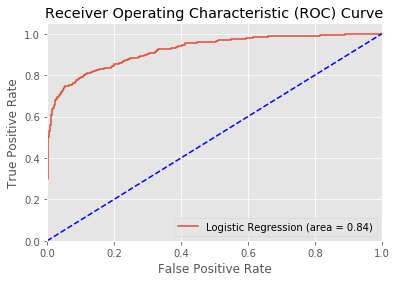

In [114]:
# Using SMOTE, I will oversample the training data for the minority class
# Only going to do this on the training set as to not have any info in the test data used for synthetic observations\
#### This will avoid bleeding from the test dataset

X = dfreg.loc[:, dfreg.columns != 'BAD']
y = dfreg.loc[:, dfreg.columns == 'BAD']
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['BAD'])
# we can Check the numbers of our data
print("length of the oversampled data is ",len(os_data_X))
print("Number of repaid loans in the oversampled data",len(os_data_y[os_data_y['BAD']==0]))
print("Number of defaulted loans",len(os_data_y[os_data_y['BAD']==1]))
print("Proportion of repaid loans data in oversampled data is ",len(os_data_y[os_data_y['BAD']==0])/len(os_data_X))
print("Proportion of defaulted loans data in oversampled data is ",len(os_data_y[os_data_y['BAD']==1])/len(os_data_X))
# both classes have even sample sizes in the training set now
print()

dfreg_variables=dfreg.columns.values.tolist()
y=['BAD']
X=[i for i in dfreg_variables if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)
print()
# Output indicates in the TRUE and 1 values that all columns are helpful in predicting, which makes sense for this data because of the types and the small size

# So the RFE shows we would like to keep all features in the data as x- vars
cols=['LOAN', 'MORTDUE','VALUE', 'YOJ','DEROG', 'DELINQ',
              'CLAGE', 'NINQ','CLNO', 'DEBTINC','DebtCon', 'Mgr',
              'Office', 'Other','ProfExe', 'Sales'] 
X=os_data_X[cols]
y=os_data_y['BAD']

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print('RFE Recommended Multiple Log Regression Variables (All)')
print(result.summary2())
print()

# BAD P-Values for:
### VALUE
### YOJ
### DebtCon

# Remove the above that are not statistically significant
cols=['DEROG', 'DELINQ','CLAGE', 'NINQ','CLNO', 'DEBTINC', 'Mgr',
              'Office', 'Other','ProfExe', 'Sales'] 
X=os_data_X[cols]
y=os_data_y['BAD']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print('Optimal Multiple Log Regression Variables')
print(result.summary2())


from sklearn.linear_model import LogisticRegression
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('Logistic Regression Confusion Matrix on the test set: ')
print(confusion_matrix)

##  [589  62]
##  [139 505 # 1094 correct predictions of 1295 total
# 84% accuracy is great, but now must check recall too 

from sklearn.metrics import classification_report
print()
print('Classification Report: ')
print(classification_report(y_test, y_pred))
# recall has a weighted average of 84% between both binary options so this is a great model now

# I will plot the Receiver operating characteristic (ROC) curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()
# This curve looks great for my supervised predictive model
# Blue dotted line = ROC of a random binary classifier (we want the red line as far from the blue as possible to maximize the area between the two curves)
# True positive rate here is the recall (sensitivity or probability of detection)
# False positive rate here is the probability of false alarm (1- specificity)
# This shows the most optimal model and is a good illustration when altering which independent variables to use in the model
# I used this to come to my ultimate conslussion about which variables to use by the largest area under the curve and sharpest increase in logsitic regression curve
# A sharp slope is good in this case because it indicates the true positive rate grows significantly faster than the false positive rate
# In practical terms, the rate of predicting an actual defaul is much faster than predicting an actual default as a repaid loan
# This will save a lot of money through the loan approval and mitigation process




In [27]:
# USING THE AID OF MY CORRELATION MATRIX AT THE START OF MY CODE, I WILL PERFROM UNSUPERVISED MACHINE LEARNING
# I WILL USE THE TWO VARIABLES WERE MOST CORRELATED WITH BAD (DEROG AND DELINQ) TO CLUSTER AND THEN OBSERVE IF THESE ARE ACTUALLY BAD=1 OR BAD=0

print(df)
dfk0 = df['BAD']
dfk1 = df['DebtCon']
dfk2 = df['HomeImp']
dfk3 = df['Mgr']
dfk4 = df['Office']
dfk5 = df['Other']
dfk6 = df['ProfExe']
dfk7 = df['Sales']
dfk8 = df['Self']



dfk = pd.concat([dfk0, dfk1], axis=1)
dfk = pd.concat([dfk, dfk2], axis=1)
dfk = pd.concat([dfk, dfk3], axis=1)
dfk = pd.concat([dfk, dfk4], axis=1)
dfk = pd.concat([dfk, dfk5], axis=1)
dfk = pd.concat([dfk, dfk6], axis=1)
dfk = pd.concat([dfk, dfk7], axis=1)
dfk = pd.concat([dfk, dfk8], axis=1)
print(dfk)

# NOW I WILL WRITE AN APRIORI ASSOCIATION RULE UNSUPERVISED ALGORITHM

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from apyori import apriori

dfk.info()

# must convert pandas dataframe into a list of lists
loans = []
for i in range(0, 3364):
    loans.append([str(dfk.values[i,j]) for j in range(0, 9)])

association_rules = apriori(loans, min_support=.1, min_confidence=.3, min_lift=.5, min_length=3)
association_rules

association_results = list(association_rules)

print(len(association_results))

print(association_results)



      BAD   LOAN   MORTDUE     VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  \
5       1   1700   30548.0   67278.5   9.0    0.0     0.0  101.466002   1.0   
7       1   1800   28502.0   67278.5  11.0    0.0     0.0   88.766030   0.0   
19      0   2300  102370.0  120953.0   2.0    0.0     0.0   90.992533   0.0   
25      1   2400   34863.0   47471.0  12.0    0.0     0.0   70.491080   1.0   
26      0   2400   98449.0  117195.0   4.0    0.0     0.0   93.811775   0.0   
...   ...    ...       ...       ...   ...    ...     ...         ...   ...   
5955    0  88900   57264.0   90185.0  16.0    0.0     0.0  221.808717   0.0   
5956    0  89000   54576.0   92937.0  16.0    0.0     0.0  208.692070   0.0   
5957    0  89200   54045.0   92924.0  15.0    0.0     0.0  212.279697   0.0   
5958    0  89800   50370.0   91861.0  14.0    0.0     0.0  213.892709   0.0   
5959    0  89900   48811.0   88934.0  15.0    0.0     0.0  219.601002   0.0   

      CLNO    DEBTINC  DebtCon  HomeImp  Mgr  Offic

In [29]:
# NOW I WILL WRITE AN APRIORI ASSOCIATION RULE UNSUPERVISED ALGORITHM

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from apyori import apriori


B2 = dfreg.loc[:, dfreg.columns != 'BAD']
C2 = B2.loc[:, B2.columns != 'DebtCon']
D2 = C2.loc[:, C2.columns != 'HomeImp']
E2 = D2.loc[:, D2.columns != 'Mgr']
F2 = E2.loc[:, E2.columns != 'Office']
G2 = F2.loc[:, F2.columns != 'Other']
H2 = G2.loc[:, G2.columns != 'ProfExe']
I2 = H2.loc[:, H2.columns != 'Sales']
J2 = I2.loc[:, I2.columns != 'Self']

J2.info()

from mlxtend.frequent_patterns import association_rules

cats = apriori(J2, min_support=0.4)
association_rules(cats, metric="confidence", min_threshold=0.7)
 # disregard, because I could not get it to fully run

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3364 entries, 5 to 5959
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   LOAN     3364 non-null   int64  
 1   MORTDUE  3364 non-null   float64
 2   VALUE    3364 non-null   float64
 3   YOJ      3364 non-null   float64
 4   DEROG    3364 non-null   float64
 5   DELINQ   3364 non-null   float64
 6   CLAGE    3364 non-null   float64
 7   NINQ     3364 non-null   float64
 8   CLNO     3364 non-null   float64
 9   DEBTINC  3364 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 289.1 KB


AttributeError: 'generator' object has no attribute 'columns'

In [31]:

from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA



N = dfreg.loc[:, dfreg.columns != 'LOAN']
O = N.loc[:, N.columns != 'MORTDUE']
P = O.loc[:, O.columns != 'VALUE']
Q = P.loc[:, P.columns != 'YOJ']
Z = Q.loc[:, Q.columns != 'DebtCon']
clustering_kmeans = KMeans(n_clusters=2, precompute_distances="auto", n_jobs=-1)
Z['clusters'] = clustering_kmeans.fit_predict(Z)



print(Z.tail(40))

reduced_data = PCA(n_components=pca_num_components).fit_transform(R)
results = pd.DataFrame(reduced_data,columns=['pca1','pca2'])

sns.scatterplot(x="pca1", y="pca2", hue=Z['clusters'], Z=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()


# This does not look great. Clusters some BAD together but also misses some that are BAD=1 as BAD=0


/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:970: FutureWarning: 'precompute_distances' was deprecated in version 0.23 and will be removed in 0.25. It has no effect
  "effect", FutureWarning)
/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


      BAD  DEROG  DELINQ       CLAGE  NINQ  CLNO     DEBTINC  Mgr  Office  \
5898    0    0.0     0.0   96.693929   0.0  20.0   28.385501    0       0   
5899    0    0.0     0.0   96.266068   0.0  21.0   29.366966    0       0   
5901    0    0.0     0.0  176.742048   1.0  26.0   38.069751    0       0   
5902    0    0.0     0.0  304.314615   2.0  26.0   36.436252    0       0   
5903    0    0.0     0.0  297.307481   1.0  25.0   37.636502    0       0   
5906    0    0.0     1.0  136.947811   0.0  11.0   40.531823    0       1   
5907    0    0.0     0.0  129.084479   0.0  11.0   43.519943    0       1   
5908    0    0.0     1.0  116.906104   0.0  11.0   43.368718    0       1   
5909    0    0.0     0.0  128.780514   0.0  12.0   43.191163    0       1   
5910    0    0.0     0.0  124.243077   0.0  12.0   41.444011    0       1   
5911    0    0.0     1.0  134.680907   0.0  11.0   43.568864    0       1   
5912    1    0.0     0.0   98.808206   1.0  21.0  144.189001    0       0   

NameError: name 'pca_num_components' is not defined

SyntaxError: invalid syntax (<ipython-input-33-9f0091ba031e>, line 29)

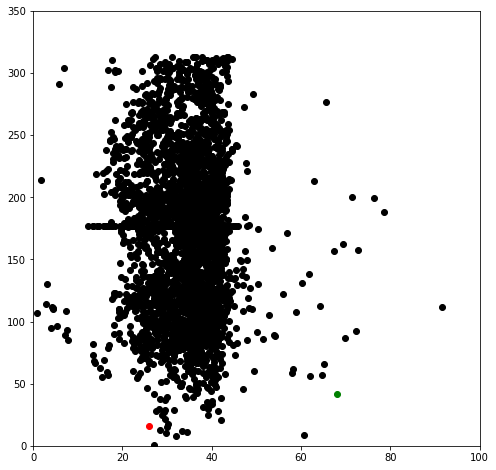

In [34]:

np.random.seed(200)
k = 2
# centroids[i] = [x, y]
centroids = {
    i+1: [np.random.randint(0, 80), np.random.randint(0, 80)]
    for i in range(k)
}

fig = plt.figure(figsize=(8, 8))
plt.scatter(df['DEBTINC'], df['CLAGE'], color='k')
colmap = {1: 'r', 2: 'g'}
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 100)
plt.ylim(0, 350)
plt.show()

      BAD   LOAN  MORTDUE    VALUE   YOJ  DEROG  DELINQ       CLAGE  NINQ  \
5955    0  88900  57264.0  90185.0  16.0    0.0     0.0  221.808717   0.0   
5956    0  89000  54576.0  92937.0  16.0    0.0     0.0  208.692070   0.0   
5957    0  89200  54045.0  92924.0  15.0    0.0     0.0  212.279697   0.0   
5958    0  89800  50370.0  91861.0  14.0    0.0     0.0  213.892709   0.0   
5959    0  89900  48811.0  88934.0  15.0    0.0     0.0  219.601002   0.0   

      CLNO  ...  Mgr  Office  Other  ProfExe  Sales  Self  distance_from_1  \
5955  16.0  ...    0       0      1        0      0     0       206.057001   
5956  15.0  ...    0       0      1        0      0     0       192.944170   
5957  15.0  ...    0       0      1        0      0     0       196.512208   
5958  16.0  ...    0       0      1        0      0     0       198.068409   
5959  16.0  ...    0       0      1        0      0     0       203.781351   

      distance_from_2  closest  color  
5955       182.614340       

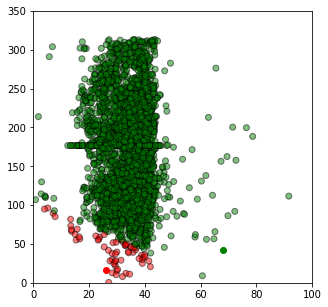

In [35]:
def assignment(df, centroids):
    for i in centroids.keys():
        # sqrt((x1 - x2)^2 - (y1 - y2)^2)
        df['distance_from_{}'.format(i)] = (
            np.sqrt(
                (df['DEBTINC'] - centroids[i][0]) ** 2
                + (df['CLAGE'] - centroids[i][1]) ** 2
            )
        )
    centroid_distance_cols = ['distance_from_{}'.format(i) for i in centroids.keys()]
    df['closest'] = df.loc[:, centroid_distance_cols].idxmin(axis=1)
    df['closest'] = df['closest'].map(lambda x: int(x.lstrip('distance_from_')))
    df['color'] = df['closest'].map(lambda x: colmap[x])
    return df

df = assignment(df, centroids)
print(df.tail())

fig = plt.figure(figsize=(5, 5))
plt.scatter(df['DEBTINC'], df['CLAGE'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 100)
plt.ylim(0, 350)
plt.show()




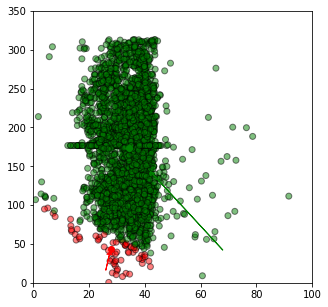

In [36]:
import copy

old_centroids = copy.deepcopy(centroids)

def update(k):
    for i in centroids.keys():
        centroids[i][0] = np.mean(df[df['closest'] == i]['DEBTINC'])
        centroids[i][1] = np.mean(df[df['closest'] == i]['CLAGE'])
    return k

centroids = update(centroids)
    
fig = plt.figure(figsize=(5, 5))
ax = plt.axes()
plt.scatter(df['DEBTINC'], df['CLAGE'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 100)
plt.ylim(0, 350)
for i in old_centroids.keys():
    old_x = old_centroids[i][0]
    old_y = old_centroids[i][1]
    dx = (centroids[i][0] - old_centroids[i][0]) * 0.75
    dy = (centroids[i][1] - old_centroids[i][1]) * 0.75
    ax.arrow(old_x, old_y, dx, dy, head_width=2, head_length=3, fc=colmap[i], ec=colmap[i])
plt.show()

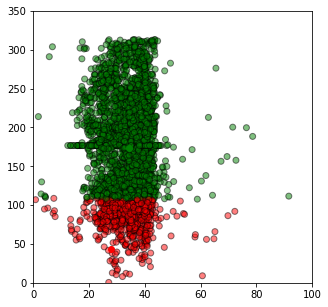

In [37]:
df = assignment(df, centroids)

# Plot results
fig = plt.figure(figsize=(5, 5))
plt.scatter(df['DEBTINC'], df['CLAGE'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 100)
plt.ylim(0, 350)
plt.show()

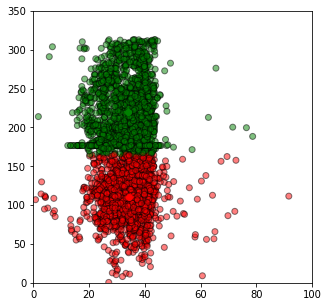

In [38]:
while True:
    closest_centroids = df['closest'].copy(deep=True)
    centroids = update(centroids)
    df = assignment(df, centroids)
    if closest_centroids.equals(df['closest']):
        break

fig = plt.figure(figsize=(5, 5))
plt.scatter(df['DEBTINC'], df['CLAGE'], color=df['color'], alpha=0.5, edgecolor='k')
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colmap[i])
plt.xlim(0, 100)
plt.ylim(0, 350)
plt.show()
# in the end there is improvement but it still is lacking accuracy in predicting the BAD category based on the graph I showed in the EDA visualization phase


In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data_scaled = scaler.fit_transform(dfreg)

# statistics of scaled data
pd.DataFrame(data_scaled).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
count,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03,3.364000e+03
mean,1.402366e-15,8.945150e-16,8.428982e-17,5.055904e-16,-2.771927e-16,-4.481816e-16,-6.077844e-16,-3.938255e-16,4.917456e-17,2.100315e-16,4.637260e-16,-4.936334e-15,1.352201e-15,5.315143e-16,3.819114e-16,-6.181474e-16,1.846340e-15
std,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00,1.000149e+00
min,-3.129077e-01,-1.605179e+00,-1.578526e+00,-1.645034e+00,-1.199446e+00,-2.534336e-01,-3.444486e-01,-2.622275e+00,-8.099157e-01,-2.785112e+00,-4.188222e+00,-1.543018e+00,-3.929719e-01,-4.550084e-01,-7.866793e-01,-6.039088e-01,-1.265198e-01
25%,-3.129077e-01,-6.579483e-01,-5.965661e-01,-8.006144e-01,-8.044706e-01,-2.534336e-01,-3.444486e-01,-8.039012e-01,-8.099157e-01,-6.503090e-01,-6.003417e-01,-1.543018e+00,-3.929719e-01,-4.550084e-01,-7.866793e-01,-6.039088e-01,-1.265198e-01
50%,-3.129077e-01,-1.981275e-01,-1.989662e-01,-2.401948e-01,-2.778369e-01,-2.534336e-01,-3.444486e-01,8.913256e-02,1.490975e-01,1.681697e-02,1.250319e-01,6.480806e-01,-3.929719e-01,-4.550084e-01,-7.866793e-01,-6.039088e-01,-1.265198e-01
75%,-3.129077e-01,4.295278e-01,3.712048e-01,6.811587e-01,5.121137e-01,-2.534336e-01,-3.444486e-01,7.047385e-01,1.490975e-01,6.839429e-01,6.228967e-01,6.480806e-01,-3.929719e-01,-4.550084e-01,1.271166e+00,1.655879e+00,-1.265198e-01
max,3.195831e+00,6.506059e+00,7.167264e+00,2.772982e+00,4.198550e+00,1.700468e+01,1.200870e+01,2.188499e+00,3.026137e+00,2.285045e+00,1.384281e+01,6.480806e-01,2.544711e+00,2.197762e+00,1.271166e+00,1.655879e+00,7.903904e+00


In [116]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++') # desired for my purposes is 2 but must check inertia of fitted first

# fitting the k means algorithm on scaled data
kmeans.fit(data_scaled)

print('Inertia on fitted data: ', kmeans.inertia_)


Inertia on fitted data:  51773.51796530402


/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)
/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureW

Text(0, 0.5, 'Inertia')

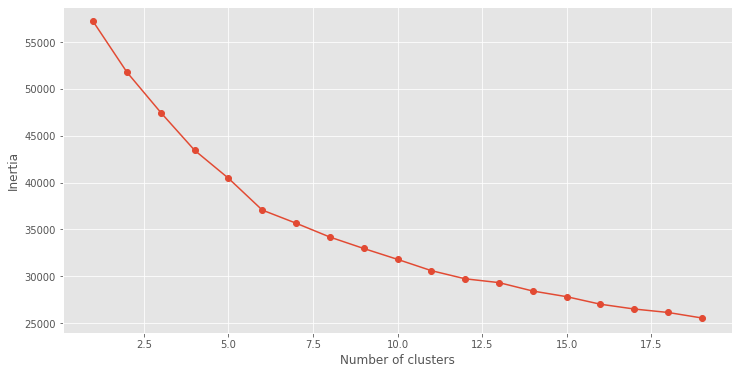

In [117]:
# fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,20):
    kmeans = KMeans(n_jobs = -1, n_clusters = cluster, init='k-means++')
    kmeans.fit(data_scaled)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,20), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

# elbow looks to be about 6, 7 or 8 (thats how many clusters I should use based on this model)

In [118]:
# k means using 6 clusters and k-means++ initialization
kmeans = KMeans(n_jobs = -1, n_clusters = 6, init='k-means++')
kmeans.fit(data_scaled)
pred = kmeans.predict(data_scaled)

/Users/mattmcdonnell/Downloads/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [122]:
frame = pd.DataFrame(data_scaled)
frame['cluster'] = pred
frame['cluster'].value_counts()
# Cluster   Count
#    0      1163
#    2       926
#    1       539
#    3       412
#    5       271
#    4        53

# I broke it up into 6 clusters to then be able to break it down into smaller clusters that would be recognized.....
# .... as BAD=1 and BAD=0 
# For instance, Clusters 4 and 5 combined could be BAD=1 because combined count is about 325 and actual is 300


# This clustering method could be used as a system of risk ranking and binning obligators into certain interest rate pools based on their presumed risk
# Could work very well in interest rate offerings and refusal to loan to clusters showing highest risk of defaulting

2    1163
1     926
0     539
3     412
5     271
4      53
Name: cluster, dtype: int64

In [ ]:
# Supervised Algorithm Citation
# https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

# Unsupervised Algorithm Citation
# https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/#comment-160970

# Unbalanced Data Citation
# https://kite.com/blog/python/smote-python-imbalanced-learn-for-oversampling/

# Some SMOTE Analysis
# https://medium.com/@saeedAR/smote-and-near-miss-in-python-machine-learning-in-imbalanced-datasets-b7976d9a7a79
    
: 
    